# Title

This Notebook...

## Initialization

### Imports

In [190]:
import sys
import datetime
import csv
import time as timeModule
import numpy
import scipy
import scipy.ndimage
import scipy.ndimage.measurements
import scipy.ndimage.filters
import skimage
import skimage.measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

### Helper Functions

In [140]:
debugMode = True;

In [141]:
def dprint(objectToPrint, depth = 0):
    indent = "  " * depth
    if (debugMode):
        print(indent + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) + " | " + str(objectToPrint))

In [142]:
def progressBar(message, value, endvalue, bar_length = 20):
    if debugMode:
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        sys.stdout.write("\r" 
                         + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 
                         + " | " 
                         + message 
                         + ": [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        if value == endvalue:
            sys.stdout.write("\n")
        sys.stdout.flush()

In [143]:
def extractAttribute(bpsCode, startBit, endBit):
    return int(bpsCode, 16) >> (80 - endBit) & int("1" * (endBit - startBit), 2)

In [144]:
print(extractAttribute("00D00C03405B18200005", 14, 24))
print(extractAttribute("00D00C03405B18200005", 24, 38))

12
208


## Classes

In [145]:
class BPSDetector:
    bpsCode = None
    roadNumber = None
    hectometer = None
    additionalMeters = None
    def __init__(self, bpsCode):
        self.bpsCode = bpsCode
        self.roadNumber = extractAttribute(bpsCode, 14, 24)
        self.hectometer = extractAttribute(bpsCode, 24, 38)
        self.additionalMeters = extractAttribute(bpsCode, 38, 48)
    def getBPSCoder(self):
        return self.bpsCode
    def getRoadNumber(self):
        return self.roadNumber
    def getMeter(self):
        return 100 * self.hectometer + self.additionalMeters
    def __str__(self):
        return "bpsCode: {} | roadNumber: {} | hectometer: {} | additionalMeters: {}".format(self.bpsCode, self.roadNumber, self.hectometer, self.additionalMeters)

In [146]:
bpsDetector = BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


In [147]:
class Road:
    roadNumber = None
    bpsDetectors = None
    spaceToSpaceIndex = None
    def __init__(self, roadNumber):
        self.roadNumber = roadNumber
        self.bpsDetectors = set()
        self.spaceToSpaceIndex = dict()
    def addBPSDetector(self, bpsDetector):
        self.bpsDetectors.add(bpsDetector)
    def indexDetectorSpaces(self):
        spaceSet = set()
        for bpsDetector in self.bpsDetectors:
            spaceSet.add(bpsDetector.getMeter())
        sortedSpaceSet = sorted(spaceSet)
        for spaceIndex in range(len(sortedSpaceSet)):
            self.spaceToSpaceIndex[sortedSpaceSet[spaceIndex]] = spaceIndex
    def getBPSDetectors(self):
        return self.bpsDetectors
    def getSpaceToSpaceIndex(self):
        return self.spaceToSpaceIndex
    def __str__(self):
        return "roadNumber: {} | len(bpsDetectors): {} | len(spaceToSpaceIndex): {}".format(self.roadNumber, len(self.bpsDetectors), len(self.spaceToSpaceIndex))

In [148]:
road = Road(15)
road.addBPSDetector(bpsDetector)
road.indexDetectorSpaces()
print(road)
road.getSpaceToSpaceIndex()

roadNumber: 15 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 1


{20891: 0}

In [149]:
class Detection:
    code = None
    space = None
    time = None
    speed = None
    flow = None
    def __init__(self, code, space, time, speed, flow):
        self.code = code
        self.space = space
        self.time = time
        self.speed = speed
        self.flow = flow
    def getCode(self):
        return self.code
    def getSpace(self):
        return self.space
    def getTime(self):
        return self.time
    def getSpeed(self):
        return self.speed
    def getFlow(self):
        return self.flow
    def __str__(self):
        return "code: {} | space: {} | time: {} | speed: {} | flow: {}".format(self.code, self.space, self.time, self.speed, self.flow)

## Roads

In [150]:
def readCSVToBPSCodes(fileName):
    dprint("Starting readCSVToBPSCodes()")
    result = []
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[3] == "R":
                result.append(row[0])
    dprint("Ending readCSVToBPSCodes()")
    return result

In [151]:
bpsCodes = readCSVToBPSCodes("Test_Data\BPS_20171120.csv")

2017-11-28 15:33:18 | Starting readCSVToBPSCodes()
2017-11-28 15:33:18 | Ending readCSVToBPSCodes()


In [152]:
for bpsCode in bpsCodes:
    print(bpsCode)

10D00100A055D0070007
10D00100A055D007000B
10D00100A055D007000F
10D00100B85ED0070007
10D00100B85ED007000B
10D00100B85ED007000F
10D00100D05CD0070007
10D00100D05CD007000B
10D00100D05CD007000F
10D00100D05CD0070013
10D00100D05CD0070017
10D00100DC02D0070007
10D00100DC02D007000B
10D00100DC02D007000F
10D00100DC02D0070013
10D00100DC02D0070017
10D00100F41AD0070007
10D00100F41AD007000B
10D00100F41AD007000F
10D00100F41AD0070013
10D001010049D0070007
10D001010049D007000B
10D001010049D007000F
10D001010049D0070013
10D001011805D0070007
10D001011805D007000B
10D001011805D007000F
10D001011805D0070013
10D001011C62D007000B
10D001011C62D007000F
10D001011C62D0070013
10D001011C62D0070017
10D001012C00D0070007
10D001012C00D007000B
10D001012C00D007000F
10D001012C00D0070013
10D001012C00D0070307
10D001012C00D007030B
10D001013800D0070007
10D001013800D007000B
10D001013800D007000F
10D001013800D0070013
10D001013800D0070307
10D001013800D007030B
10D001014063D0070007
10D001014063D007000B
10D001014063D007000F
10D001014063D

10D001189400D007000B
10D00118A43CD0070007
10D00118A43CD007000B
10D00118BC5FD0070007
10D00118BC5FD007000B
10D00204D037D0070007
10D00204D037D007000B
10D00204D037D0070307
10D00204D85AD0070007
10D00204D85AD007000B
10D00204D85AD0070307
10D00204E40FD0070007
10D00204E40FD007000B
10D00204F800D0070007
10D002050C00D0070007
10D002050C00D007000B
10D002050C00D007000F
10D002050C00D0070013
10D002051800D0070007
10D002051800D007000B
10D002051800D007000F
10D002051800D0070013
10D002052400D0070007
10D002052400D007000B
10D002052400D007000F
10D002052400D0070013
10D002052C05D0070007
10D002052C05D007000B
10D002052C05D007000F
10D002052C05D0070013
10D002053C41D0070007
10D002053C41D007000B
10D002053C41D007000F
10D002053C41D0070013
10D002055032D0070007
10D002055032D007000B
10D002055032D007000F
10D002055032D0070087
10D002056028D0070007
10D002056028D007000B
10D002056028D007000F
10D002057000D0070007
10D002057000D007000B
10D002057000D007000F
10D00205801ED0070007
10D00205801ED007000B
10D00205801ED007000F
10D002058C5AD

10D0020C9000D0070307
10D0020C9C2DD0070007
10D0020C9C2DD007000B
10D0020C9C2DD007000F
10D0020C9C2DD0070013
10D0020C9C2DD0070307
10D0020CB032D0070007
10D0020CB032D007000B
10D0020CB032D007000F
10D0020CB032D0070013
10D0020CBC00D0070007
10D0020CBC00D007000B
10D0020CBC00D007000F
10D0020CBC00D0070013
10D0020CCC2DD0070007
10D0020CCC2DD007000B
10D0020CCC2DD007000F
10D0020CCC2DD0070013
10D0020CDC23D0070007
10D0020CDC23D007000B
10D0020CDC23D007000F
10D0020CDC23D0070013
10D0020CEC32D0070007
10D0020CEC32D007000B
10D0020CEC32D007000F
10D0020CEC32D0070013
10D0020CF441D0070007
10D0020CF441D007000B
10D0020CF441D007000F
10D0020CF441D0070013
10D0020D0C00D0070007
10D0020D0C00D007000B
10D0020D0C00D007000F
10D0020D0C00D0070013
10D0020D2000D0070007
10D0020D2000D007000B
10D0020D2000D007000F
10D0020D2000D0070013
10D0020D2000D0070017
10D0020D2832D0070007
10D0020D2832D007000B
10D0020D2832D007000F
10D0020D2832D0070013
10D0020D2832D0070307
10D0020D380AD0070007
10D0020D380AD007000B
10D0020D380AD007000F
10D0020D380AD

10D002163037D007008B
10D002163C37D0070007
10D002163C37D007000B
10D002163C37D0070087
10D002163C37D007008B
10D002164C55D0070007
10D002164C55D007000B
10D00216603CD0070007
10D00216603CD007000B
10D00216742DD0070007
10D00216742DD007000B
10D00218300AD0070007
10D00218300AD007000B
10D002183840D0070007
10D002183840D007000B
10D002183840D007000F
10D002184C3CD0070007
10D002184C3CD007000B
10D002185834D0070007
10D002185834D007000B
10D002186046D0070007
10D002186046D007000B
10D002186C2DD0070007
10D002186C2DD007000B
10D002187819D0070007
10D002187819D007000B
10D002188805D0070007
10D002188805D007000B
10D002188805D007000F
10D00218944BD0070007
10D00218944BD007000B
10D00218944BD007000F
10D00218A45FD0070007
10D00218A45FD007000B
10D00218A45FD007000F
10D00218B441D0070007
10D00218B441D007000B
10D00218C01ED0070007
10D00218C01ED007000B
10D00218CC3CD0070007
10D00218CC3CD007000B
10D00218E021D0070007
10D00218E021D007000B
10D00218F02DD0070007
10D00218F02DD007000B
10D00218FC5FD0070007
10D00218FC5FD007000B
10D002191055D

10D00501B851D007000B
10D00501D015D0070007
10D00501D015D007000B
10D00501E43DD0070007
10D00501E43DD007000B
10D00501FC01D0070007
10D00501FC01D007000B
10D005020442D0070007
10D005020442D007000B
10D005021841D0070007
10D005021841D007000B
10D005022429D0070007
10D005022429D007000B
10D005023047D0070007
10D005023047D007000B
10D005023047D0070307
10D005023C5ED0070007
10D005023C5ED007000B
10D005023C5ED0070307
10D005024C43D0070007
10D005024C43D007000B
10D005026041D0070007
10D005026041D007000B
10D00502741ED0070007
10D00502741ED007000B
10D005028832D0070007
10D005028832D007000B
10D005029C4ED0070007
10D005029C4ED007000B
10D00502B427D0070007
10D00502B427D007000B
10D00502C849D0070007
10D00502C849D007000B
10D00502E437D0070007
10D00502E437D007000B
10D00502E437D007000F
10D00502E437D0070187
10D00502EC4BD0070007
10D00502EC4BD007000B
10D00502EC4BD007000F
10D00502EC4BD0070013
10D00502EC4BD0070187
10D006068036D0070007
10D006068036D007000B
10D006068036D007000F
10D006068859D0070007
10D006068859D007000B
10D006068859D

10D00A004C28D007000B
10D00A004C28D007000F
10D00A006428D0070007
10D00A006428D007000B
10D00A006428D007000F
10D00A008005D0070007
10D00A008005D007000B
10D00A008005D007000F
10D00A008005D0070087
10D00A009400D0070007
10D00A009400D007000B
10D00A009400D007000F
10D00A00A800D0070007
10D00A00A800D007000B
10D00A00A800D007000F
10D00A00B41ED0070007
10D00A00B41ED007000B
10D00A00B41ED007000F
10D00A00CC32D0070007
10D00A00CC32D007000B
10D00A00CC32D007000F
10D00A00E43CD0070007
10D00A00E43CD007000B
10D00A00E43CD007000F
10D00A00FC3CD0070007
10D00A00FC3CD007000B
10D00A00FC3CD007000F
10D00A010C55D0070007
10D00A010C55D007000B
10D00A010C55D007000F
10D00A01143CD0070007
10D00A01143CD007000B
10D00A01143CD007000F
10D00A01200AD0070007
10D00A01200AD007000B
10D00A01200AD007000F
10D00A01283CD0070007
10D00A01283CD007000B
10D00A01283CD007000F
10D00A013800D0070007
10D00A013800D007000B
10D00A013800D007000F
10D00A014014D0070007
10D00A014014D007000B
10D00A014014D007000F
10D00A015400D0070007
10D00A015400D007000B
10D00A015400D

10D00C022450D007000F
10D00C023400D0070007
10D00C023400D007000B
10D00C023400D007000F
10D00C02400FD0070007
10D00C02400FD007000B
10D00C02400FD007000F
10D00C025019D0070007
10D00C025019D007000B
10D00C025019D007000F
10D00C026032D0070007
10D00C026032D007000B
10D00C026032D007000F
10D00C027446D0070007
10D00C027446D007000B
10D00C027446D007000F
10D00C028032D0070007
10D00C028032D007000B
10D00C028032D007000F
10D00C02983CD0070007
10D00C02983CD007000B
10D00C02983CD007000F
10D00C02983CD0070307
10D00C02A832D0070007
10D00C02A832D007000B
10D00C02A832D007000F
10D00C02A832D0070307
10D00C02B81ED0070007
10D00C02B81ED007000B
10D00C02B81ED007000F
10D00C02B81ED0070307
10D00C02CC0AD0070007
10D00C02CC0AD007000B
10D00C02CC0AD007000F
10D00C02E000D0070007
10D00C02E000D007000B
10D00C02E000D007000F
10D00C02F800D0070007
10D00C02F800D007000B
10D00C02F800D007000F
10D00C031032D0070007
10D00C031032D007000B
10D00C031032D007000F
10D00C032432D0070007
10D00C032432D007000B
10D00C032432D007000F
10D00C03340AD0070007
10D00C03340AD

10D00C0C840FD0070007
10D00C0C840FD007000B
10D00C0C840FD007000F
10D00C0C9000D0070007
10D00C0C9000D007000B
10D00C0C9000D007000F
10D00C0C9832D0070087
10D00C0CA041D0070007
10D00C0CA041D007000B
10D00C0CA041D007000F
10D00C0CB40FD0070007
10D00C0CB40FD007000B
10D00C0CB40FD007000F
10D00C0CC400D0070007
10D00C0CC400D007000B
10D00C0CC400D007000F
10D00C0CD80FD0070007
10D00C0CD80FD007000B
10D00C0CD80FD007000F
10D00C0CE832D0070007
10D00C0CE832D007000B
10D00C0CE832D007000F
10D00C0CFC0FD0070007
10D00C0CFC0FD007000B
10D00C0CFC0FD007000F
10D00C0D0C32D0070007
10D00C0D0C32D007000B
10D00C0D0C32D007000F
10D00C0D2041D0070007
10D00C0D2041D007000B
10D00C0D2041D007000F
10D00C0D3841D0070007
10D00C0D3841D007000B
10D00C0D3841D007000F
10D00C0D4832D0070007
10D00C0D4832D007000B
10D00C0D4832D007000F
10D00C0D5C0FD0070007
10D00C0D5C0FD007000B
10D00C0D5C0FD007000F
10D00C0D6800D0070007
10D00C0D6800D007000B
10D00C0D6800D007000F
10D00C0D7841D0070007
10D00C0D7841D007000B
10D00C0D7841D007000F
10D00C0D8C00D0070007
10D00C0D8C00D

10D00F0E7832D0070007
10D00F0E7832D007000B
10D00F0E8828D0070007
10D00F0E8828D007000B
10D00F0E9800D0070007
10D00F0E9800D007000B
10D00F0EA80AD0070007
10D00F0EA80AD007000B
10D00F0EB846D0070007
10D00F0EB846D007000B
10D00F0EB846D0070087
10D00F0EC05AD0070007
10D00F0EC05AD007000B
10D00F0ECC19D0070007
10D00F0ECC19D007000B
10D00F0EDC5AD0070007
10D00F0EDC5AD007000B
10D00F0EF43CD0070007
10D00F0EF43CD007000B
10D00F0F083CD0070007
10D00F0F083CD007000B
10D00F0F1850D0070007
10D00F0F1850D007000B
10D00F0F3000D0070007
10D00F0F3000D007000B
10D00F0F403CD0070007
10D00F0F403CD007000B
10D00F0F5441D0070007
10D00F0F5441D007000B
10D00F0F6800D0070007
10D00F0F6800D007000B
10D00F0F7832D0070007
10D00F0F7832D007000B
10D00F0F8432D0070007
10D00F0F8432D007000B
10D00F0F8832D0070087
10D00F0F901ED0070007
10D00F0F901ED007000B
10D00F0FA000D0070007
10D00F0FA000D007000B
10D00F0FB800D0070007
10D00F0FB800D007000B
10D00F0FD000D0070007
10D00F0FD000D007000B
10D00F0FDC00D0070007
10D00F0FDC00D007000B
10D00F176C55D0070007
10D00F176C55D

10D01B062832D0070007
10D01B062832D007000B
10D01B062832D007000F
10D01B063C32D0070007
10D01B063C32D007000B
10D01B063C32D007000F
10D01B065028D0070007
10D01B065028D007000B
10D01B065028D007000F
10D01B066800D0070007
10D01B066800D007000B
10D01B066800D007000F
10D01B067C00D0070007
10D01B067C00D007000B
10D01B067C00D007000F
10D01B068C0AD0070007
10D01B068C0AD007000B
10D01B068C0AD007000F
10D01B069C50D0070007
10D01B069C50D007000B
10D01B069C50D007000F
10D01B06B05AD0070007
10D01B06B05AD007000B
10D01B06CC00D0070007
10D01B06CC00D007000B
10D01B06DC00D0070007
10D01B06DC00D007000B
10D01B06F000D0070007
10D01B06F000D007000B
10D01B070000D0070007
10D01B070000D007000B
10D01B07180AD0070007
10D01B07180AD007000B
10D01B072C00D0070007
10D01B072C00D007000B
10D01B074032D0070007
10D01B074032D007000B
10D01B075446D0070007
10D01B075446D007000B
10D01B07685AD0070007
10D01B07685AD007000B
10D01B07800AD0070007
10D01B07800AD007000B
10D01B079414D0070007
10D01B079414D007000B
10D01B07A832D0070007
10D01B07A832D007000B
10D01B07BC46D

10D01C05440AD0070007
10D01C05440AD007000B
10D01C055C5AD0070007
10D01C055C5AD007000B
10D01C057800D0070007
10D01C057800D007000B
10D01C058405D0070007
10D01C058405D007000B
10D01C05900AD0070007
10D01C05900AD007000B
10D01C05A832D0070007
10D01C05A832D007000B
10D01C05C400D0070007
10D01C05C400D007000B
10D01C0CF000D0070007
10D01C0CF000D007000B
10D01C0D043ED0070007
10D01C0D043ED007000B
10D01C0D1C0AD0070007
10D01C0D1C0AD007000B
10D01C0D3432D0070007
10D01C0D3432D007000B
10D01C0D4450D0070007
10D01C0D4450D007000B
10D01C0D5014D0070007
10D01C0D5014D007000B
10D01C0D5455D0070107
10D01C0D6400D0070007
10D01C0D6400D007000B
10D01C0D7832D0070007
10D01C0D7832D007000B
10D01C0D7832D007000F
10D01C0D7832D0070013
10D01C0D8C28D0070007
10D01C0D8C28D007000B
10D01C0D8C28D007000F
10D01C0D8C28D0070013
10D01C0DA800D0070007
10D01C0DA800D007000B
10D01C0DA800D007000F
10D01C0DA800D0070087
10D01C0E2832D0070007
10D01C0E2832D007000B
10D01C0E2832D007000F
10D01C0E2832D0070087
10D01C0E3050D0070007
10D01C0E3050D007000B
10D01C0E3050D

10D03218D44BD007000B
10D03218D44BD007000F
10D03218D450D0070007
10D03218D450D007000B
10D03218D450D007000F
10D03218E805D0070007
10D03218E805D007000B
10D03218E805D007000F
10D032190005D0070007
10D032190005D007000B
10D032190005D007000F
10D03219000AD0070007
10D03219000AD007000B
10D03219000AD007000F
10D032191805D0070007
10D032191805D007000B
10D032191805D007000F
10D032192400D0070007
10D032192400D007000B
10D032192400D007000F
10D032193034D0070007
10D032193034D007000B
10D032193034D007000F
10D032193C28D0070007
10D032193C28D007000B
10D032193C28D007000F
10D03219482DD0070007
10D03219482DD007000B
10D03219482DD007000F
10D032195C32D0070007
10D032195C32D007000B
10D032195C32D007000F
10D032196805D0070007
10D032196805D007000B
10D032196805D007000F
10D032197C41D0070007
10D032197C41D007000B
10D032197C41D007000F
10D032199441D0070007
10D032199441D007000B
10D032199441D007000F
10D032199446D0070007
10D032199446D007000B
10D032199446D007000F
10D03219AC41D0070007
10D03219AC41D007000B
10D03219AC41D007000F
10D03219BC00D

In [153]:
def parseBPSCodesToRoads(bpsCodes):
    dprint("Starting parseBPSCodesToRoads()")
    result = dict()
    for bpsCode in bpsCodes:
        bpsDetector = BPSDetector(bpsCode)
        roadNumber = bpsDetector.getRoadNumber()
        if roadNumber not in result:
            road = Road(roadNumber)
            result[roadNumber] = road
        result[roadNumber].addBPSDetector(bpsDetector)
    for key, value in result.items():
        value.indexDetectorSpaces()
    dprint("Ending parseBPSCodesToRoads()")
    return result

In [154]:
roads = parseBPSCodesToRoads(bpsCodes)

2017-11-28 15:33:19 | Starting parseBPSCodesToRoads()
2017-11-28 15:33:19 | Ending parseBPSCodesToRoads()


In [155]:
for key, value in roads.items():
    for detector in value.getBPSDetectors():
        print(detector)

bpsCode: 10D001036C48D007000B | roadNumber: 1 | hectometer: 219 | additionalMeters: 72
bpsCode: 10D001038832D0070187 | roadNumber: 1 | hectometer: 226 | additionalMeters: 50
bpsCode: 10D001037C5CD0070187 | roadNumber: 1 | hectometer: 223 | additionalMeters: 92
bpsCode: 10D001037C5CD0070007 | roadNumber: 1 | hectometer: 223 | additionalMeters: 92
bpsCode: 10D001036C48D0070187 | roadNumber: 1 | hectometer: 219 | additionalMeters: 72
bpsCode: 10D001038832D0070007 | roadNumber: 1 | hectometer: 226 | additionalMeters: 50
bpsCode: 10D001038832D007000B | roadNumber: 1 | hectometer: 226 | additionalMeters: 50
bpsCode: 10D001037C5CD007000B | roadNumber: 1 | hectometer: 223 | additionalMeters: 92
bpsCode: 10D0010E0C00D0070007 | roadNumber: 1 | hectometer: 899 | additionalMeters: 0
bpsCode: 10D0010E0C00D007000B | roadNumber: 1 | hectometer: 899 | additionalMeters: 0
bpsCode: 10D00103345AD0070007 | roadNumber: 1 | hectometer: 205 | additionalMeters: 90
bpsCode: 10D001031C46D007000F | roadNumber: 1

bpsCode: 10D00101CC62D007000B | roadNumber: 1 | hectometer: 115 | additionalMeters: 98
bpsCode: 10D00101CC62D0070007 | roadNumber: 1 | hectometer: 115 | additionalMeters: 98
bpsCode: 10D00101C428D0070017 | roadNumber: 1 | hectometer: 113 | additionalMeters: 40
bpsCode: 10D00101C428D0070013 | roadNumber: 1 | hectometer: 113 | additionalMeters: 40
bpsCode: 10D0010D8450D0070087 | roadNumber: 1 | hectometer: 865 | additionalMeters: 80
bpsCode: 10D00101C428D007000B | roadNumber: 1 | hectometer: 113 | additionalMeters: 40
bpsCode: 10D0010D9400D007000B | roadNumber: 1 | hectometer: 869 | additionalMeters: 0
bpsCode: 10D00101C428D0070007 | roadNumber: 1 | hectometer: 113 | additionalMeters: 40
bpsCode: 10D0010D4C14D007000B | roadNumber: 1 | hectometer: 851 | additionalMeters: 20
bpsCode: 10D00101B428D007001B | roadNumber: 1 | hectometer: 109 | additionalMeters: 40
bpsCode: 10D0010D380FD0070307 | roadNumber: 1 | hectometer: 846 | additionalMeters: 15
bpsCode: 10D00101B428D0070017 | roadNumber: 

bpsCode: 10D0021B045AD007000F | roadNumber: 2 | hectometer: 1729 | additionalMeters: 90
bpsCode: 10D002073C3ED0070007 | roadNumber: 2 | hectometer: 463 | additionalMeters: 62
bpsCode: 10D0021B142DD0070007 | roadNumber: 2 | hectometer: 1733 | additionalMeters: 45
bpsCode: 10D00207243FD0070017 | roadNumber: 2 | hectometer: 457 | additionalMeters: 63
bpsCode: 10D0021B142DD007000B | roadNumber: 2 | hectometer: 1733 | additionalMeters: 45
bpsCode: 10D00207243FD0070013 | roadNumber: 2 | hectometer: 457 | additionalMeters: 63
bpsCode: 10D0021B142DD007000F | roadNumber: 2 | hectometer: 1733 | additionalMeters: 45
bpsCode: 10D00207243FD007000F | roadNumber: 2 | hectometer: 457 | additionalMeters: 63
bpsCode: 10D0021B205AD0070007 | roadNumber: 2 | hectometer: 1736 | additionalMeters: 90
bpsCode: 10D00207CC31D0070017 | roadNumber: 2 | hectometer: 499 | additionalMeters: 49
bpsCode: 10D0021B205AD007000B | roadNumber: 2 | hectometer: 1736 | additionalMeters: 90
bpsCode: 10D00207243FD007000B | roadN

bpsCode: 10D002229C0AD007000B | roadNumber: 2 | hectometer: 2215 | additionalMeters: 10
bpsCode: 10D002067C02D007000B | roadNumber: 2 | hectometer: 415 | additionalMeters: 2
bpsCode: 10D0020D2000D0070007 | roadNumber: 2 | hectometer: 840 | additionalMeters: 0
bpsCode: 10D00222A43CD0070007 | roadNumber: 2 | hectometer: 2217 | additionalMeters: 60
bpsCode: 10D002067C02D007000F | roadNumber: 2 | hectometer: 415 | additionalMeters: 2
bpsCode: 10D0020D2000D007000B | roadNumber: 2 | hectometer: 840 | additionalMeters: 0
bpsCode: 10D00222A43CD007000B | roadNumber: 2 | hectometer: 2217 | additionalMeters: 60
bpsCode: 10D002067C02D0070013 | roadNumber: 2 | hectometer: 415 | additionalMeters: 2
bpsCode: 10D0020D2000D007000F | roadNumber: 2 | hectometer: 840 | additionalMeters: 0
bpsCode: 10D00222B050D0070007 | roadNumber: 2 | hectometer: 2220 | additionalMeters: 80
bpsCode: 10D002067C02D0070017 | roadNumber: 2 | hectometer: 415 | additionalMeters: 2
bpsCode: 10D0020D2000D0070013 | roadNumber: 2 

bpsCode: 10D00225682DD0070013 | roadNumber: 2 | hectometer: 2394 | additionalMeters: 45
bpsCode: 10D002257C55D0070007 | roadNumber: 2 | hectometer: 2399 | additionalMeters: 85
bpsCode: 10D002257C55D007000B | roadNumber: 2 | hectometer: 2399 | additionalMeters: 85
bpsCode: 10D002257C55D0070087 | roadNumber: 2 | hectometer: 2399 | additionalMeters: 85
bpsCode: 10D002257C55D007008B | roadNumber: 2 | hectometer: 2399 | additionalMeters: 85
bpsCode: 10D002258C19D0070007 | roadNumber: 2 | hectometer: 2403 | additionalMeters: 25
bpsCode: 10D002258C19D007000B | roadNumber: 2 | hectometer: 2403 | additionalMeters: 25
bpsCode: 10D002259833D0070007 | roadNumber: 2 | hectometer: 2406 | additionalMeters: 51
bpsCode: 10D002259833D007000B | roadNumber: 2 | hectometer: 2406 | additionalMeters: 51
bpsCode: 10D00225A048D0070007 | roadNumber: 2 | hectometer: 2408 | additionalMeters: 72
bpsCode: 10D002250C05D0070187 | roadNumber: 2 | hectometer: 2371 | additionalMeters: 5
bpsCode: 10D002250C05D007000B | r

bpsCode: 10D004018C00D0070007 | roadNumber: 4 | hectometer: 99 | additionalMeters: 0
bpsCode: 10D004026C1DD0070017 | roadNumber: 4 | hectometer: 155 | additionalMeters: 29
bpsCode: 10D004018C00D007000B | roadNumber: 4 | hectometer: 99 | additionalMeters: 0
bpsCode: 10D004026C1DD0070107 | roadNumber: 4 | hectometer: 155 | additionalMeters: 29
bpsCode: 10D004018C00D007000F | roadNumber: 4 | hectometer: 99 | additionalMeters: 0
bpsCode: 10D004028046D0070007 | roadNumber: 4 | hectometer: 160 | additionalMeters: 70
bpsCode: 10D004018C00D0070013 | roadNumber: 4 | hectometer: 99 | additionalMeters: 0
bpsCode: 10D004028046D007000B | roadNumber: 4 | hectometer: 160 | additionalMeters: 70
bpsCode: 10D00401943CD0070007 | roadNumber: 4 | hectometer: 101 | additionalMeters: 60
bpsCode: 10D004028046D007000F | roadNumber: 4 | hectometer: 160 | additionalMeters: 70
bpsCode: 10D00401943CD007000B | roadNumber: 4 | hectometer: 101 | additionalMeters: 60
bpsCode: 10D004028046D0070013 | roadNumber: 4 | hec

bpsCode: 10D00800B85FD0070307 | roadNumber: 8 | hectometer: 46 | additionalMeters: 95
bpsCode: 10D008005423D007000B | roadNumber: 8 | hectometer: 21 | additionalMeters: 35
bpsCode: 10D00800B85FD007030B | roadNumber: 8 | hectometer: 46 | additionalMeters: 95
bpsCode: 10D008005423D0070087 | roadNumber: 8 | hectometer: 21 | additionalMeters: 35
bpsCode: 10D00800C400D0070007 | roadNumber: 8 | hectometer: 49 | additionalMeters: 0
bpsCode: 10D008005423D0070187 | roadNumber: 8 | hectometer: 21 | additionalMeters: 35
bpsCode: 10D00800C400D007000B | roadNumber: 8 | hectometer: 49 | additionalMeters: 0
bpsCode: 10D008006805D0070007 | roadNumber: 8 | hectometer: 26 | additionalMeters: 5
bpsCode: 10D00800C832D0070007 | roadNumber: 8 | hectometer: 50 | additionalMeters: 50
bpsCode: 10D008006805D007000B | roadNumber: 8 | hectometer: 26 | additionalMeters: 5
bpsCode: 10D00800C832D007000B | roadNumber: 8 | hectometer: 50 | additionalMeters: 50
bpsCode: 10D00908AC3CD007000B | roadNumber: 9 | hectometer

bpsCode: 10D00C04D40FD007000F | roadNumber: 12 | hectometer: 309 | additionalMeters: 15
bpsCode: 10D00C0AB85FD0070013 | roadNumber: 12 | hectometer: 686 | additionalMeters: 95
bpsCode: 10D00C122005D0070007 | roadNumber: 12 | hectometer: 1160 | additionalMeters: 5
bpsCode: 10D00C04D40FD0070013 | roadNumber: 12 | hectometer: 309 | additionalMeters: 15
bpsCode: 10D00C0AB85FD007000F | roadNumber: 12 | hectometer: 686 | additionalMeters: 95
bpsCode: 10D00C122005D007000B | roadNumber: 12 | hectometer: 1160 | additionalMeters: 5
bpsCode: 10D00C04E800D0070007 | roadNumber: 12 | hectometer: 314 | additionalMeters: 0
bpsCode: 10D00C0AB85FD007000B | roadNumber: 12 | hectometer: 686 | additionalMeters: 95
bpsCode: 10D00C122005D007000F | roadNumber: 12 | hectometer: 1160 | additionalMeters: 5
bpsCode: 10D00C04E800D007000B | roadNumber: 12 | hectometer: 314 | additionalMeters: 0
bpsCode: 10D00C0AB85FD0070007 | roadNumber: 12 | hectometer: 686 | additionalMeters: 95
bpsCode: 10D00C122C0FD0070007 | ro

bpsCode: 10D00F03645FD007000B | roadNumber: 15 | hectometer: 217 | additionalMeters: 95
bpsCode: 10D00F03645FD0070007 | roadNumber: 15 | hectometer: 217 | additionalMeters: 95
bpsCode: 10D00F095C38D007000F | roadNumber: 15 | hectometer: 599 | additionalMeters: 56
bpsCode: 10D00F095C38D007000B | roadNumber: 15 | hectometer: 599 | additionalMeters: 56
bpsCode: 10D00F035C0AD007000B | roadNumber: 15 | hectometer: 215 | additionalMeters: 10
bpsCode: 10D00F035C0AD0070007 | roadNumber: 15 | hectometer: 215 | additionalMeters: 10
bpsCode: 10D00F095C38D0070007 | roadNumber: 15 | hectometer: 599 | additionalMeters: 56
bpsCode: 10D00F094C4CD007000F | roadNumber: 15 | hectometer: 595 | additionalMeters: 76
bpsCode: 10D00F034C00D007000B | roadNumber: 15 | hectometer: 211 | additionalMeters: 0
bpsCode: 10D00F034C00D0070007 | roadNumber: 15 | hectometer: 211 | additionalMeters: 0
bpsCode: 10D00F094C4CD007000B | roadNumber: 15 | hectometer: 595 | additionalMeters: 76
bpsCode: 10D00F033841D007000B | ro

bpsCode: 10D010047C4BD007030B | roadNumber: 16 | hectometer: 287 | additionalMeters: 75
bpsCode: 10D010047C50D0070007 | roadNumber: 16 | hectometer: 287 | additionalMeters: 80
bpsCode: 10D010047C50D007000B | roadNumber: 16 | hectometer: 287 | additionalMeters: 80
bpsCode: 10D010047C50D007000F | roadNumber: 16 | hectometer: 287 | additionalMeters: 80
bpsCode: 10D010047C50D0070013 | roadNumber: 16 | hectometer: 287 | additionalMeters: 80
bpsCode: 10D01004904BD0070307 | roadNumber: 16 | hectometer: 292 | additionalMeters: 75
bpsCode: 10D01004904BD007030B | roadNumber: 16 | hectometer: 292 | additionalMeters: 75
bpsCode: 10D010049050D0070007 | roadNumber: 16 | hectometer: 292 | additionalMeters: 80
bpsCode: 10D010049050D007000B | roadNumber: 16 | hectometer: 292 | additionalMeters: 80
bpsCode: 10D010049050D007000F | roadNumber: 16 | hectometer: 292 | additionalMeters: 80
bpsCode: 10D010049050D0070013 | roadNumber: 16 | hectometer: 292 | additionalMeters: 80
bpsCode: 10D01004B032D0070007 | 

bpsCode: 10D01C010832D007000F | roadNumber: 28 | hectometer: 66 | additionalMeters: 50
bpsCode: 10D01C106400D007000B | roadNumber: 28 | hectometer: 1049 | additionalMeters: 0
bpsCode: 10D01C106400D007000F | roadNumber: 28 | hectometer: 1049 | additionalMeters: 0
bpsCode: 10D01C107000D0070007 | roadNumber: 28 | hectometer: 1052 | additionalMeters: 0
bpsCode: 10D01C107000D007000B | roadNumber: 28 | hectometer: 1052 | additionalMeters: 0
bpsCode: 10D01C107000D007000F | roadNumber: 28 | hectometer: 1052 | additionalMeters: 0
bpsCode: 10D01C109032D0070007 | roadNumber: 28 | hectometer: 1060 | additionalMeters: 50
bpsCode: 10D01C109032D007000B | roadNumber: 28 | hectometer: 1060 | additionalMeters: 50
bpsCode: 10D01C109032D007000F | roadNumber: 28 | hectometer: 1060 | additionalMeters: 50
bpsCode: 10D01C10AC19D0070007 | roadNumber: 28 | hectometer: 1067 | additionalMeters: 25
bpsCode: 10D01C10AC19D007000B | roadNumber: 28 | hectometer: 1067 | additionalMeters: 25
bpsCode: 10D01C10AC19D007000

bpsCode: 10D04302E819D0070007 | roadNumber: 67 | hectometer: 186 | additionalMeters: 25
bpsCode: 10D04303903CD0070007 | roadNumber: 67 | hectometer: 228 | additionalMeters: 60
bpsCode: 10D04303903CD007000B | roadNumber: 67 | hectometer: 228 | additionalMeters: 60
bpsCode: 10D04303A04BD0070007 | roadNumber: 67 | hectometer: 232 | additionalMeters: 75
bpsCode: 10D04303A04BD007000B | roadNumber: 67 | hectometer: 232 | additionalMeters: 75
bpsCode: 10D04303AC28D0070007 | roadNumber: 67 | hectometer: 235 | additionalMeters: 40
bpsCode: 10D04303AC28D007000B | roadNumber: 67 | hectometer: 235 | additionalMeters: 40
bpsCode: 10D04303B811D0070007 | roadNumber: 67 | hectometer: 238 | additionalMeters: 17
bpsCode: 10D04303B811D007000B | roadNumber: 67 | hectometer: 238 | additionalMeters: 17
bpsCode: 10D04303CC4BD0070007 | roadNumber: 67 | hectometer: 243 | additionalMeters: 75
bpsCode: 10D04303CC4BD007000B | roadNumber: 67 | hectometer: 243 | additionalMeters: 75
bpsCode: 10D04303D85FD0070007 | 

## Speed and Flows

In [156]:
def readCSVToDetections(fileName):
    dprint("Starting readCSVToDetections()")
    result = set()
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[2] == "R-":
                code = row[0]
                space = int(row[1][:-1])
                timeObject = timeModule.strptime(row[6], "%H:%M")
                time = 60 * timeObject.tm_hour + timeObject.tm_min
                speed = int(row[9])
                flow = float(row[8]) / float(row[4])
                detection = Detection(code, space, time, speed, flow)
                result.add(detection)
    dprint("Ending readCSVToDetections()")
    return result

In [157]:
detections = readCSVToDetections("Test_Data\A13_20171120.csv")

2017-11-28 15:33:27 | Starting readCSVToDetections()
2017-11-28 15:33:28 | Ending readCSVToDetections()


In [158]:
for detection in detections:
    print(detection)

code: 10D00D015800D007000F | space: 8600 | time: 487 | speed: 99 | flow: 29.666666666666668
code: 10D00D02FC00D0070007 | space: 19100 | time: 69 | speed: 75 | flow: 1.0
code: 10D00D015800D007000F | space: 8600 | time: 488 | speed: 97 | flow: 30.666666666666668
code: 10D00D02EC00D007000B | space: 18700 | time: 1437 | speed: 73 | flow: 5.5
code: 10D00D015800D007000F | space: 8600 | time: 417 | speed: 101 | flow: 20.333333333333332
code: 10D00D02FC00D0070007 | space: 19100 | time: 68 | speed: 78 | flow: 1.0
code: 10D00D015800D007000F | space: 8600 | time: 418 | speed: 99 | flow: 27.0
code: 10D00D02EC00D007000B | space: 18700 | time: 1439 | speed: 80 | flow: 0.5
code: 10D00D015800D007000F | space: 8600 | time: 419 | speed: 102 | flow: 22.0
code: 10D00D02FC00D0070007 | space: 19100 | time: 1 | speed: 0 | flow: 0.0
code: 10D00D015800D007000F | space: 8600 | time: 420 | speed: 98 | flow: 23.666666666666668
code: 10D00D02FC00D0070007 | space: 19100 | time: 0 | speed: 75 | flow: 7.0
code: 10D00

code: 10D00D010C19D007000F | space: 6725 | time: 154 | speed: 99 | flow: 1.6666666666666667
code: 10D00D00D851D007000F | space: 5481 | time: 707 | speed: 98 | flow: 13.0
code: 10D00D010000D007000F | space: 6400 | time: 83 | speed: 98 | flow: 2.0
code: 10D00D010C19D007000F | space: 6725 | time: 155 | speed: 85 | flow: 0.3333333333333333
code: 10D00D00D851D007000F | space: 5481 | time: 708 | speed: 101 | flow: 16.666666666666668
code: 10D00D010000D007000F | space: 6400 | time: 84 | speed: 86 | flow: 0.3333333333333333
code: 10D00D010C19D007000F | space: 6725 | time: 156 | speed: 0 | flow: 0.0
code: 10D00D00D851D007000F | space: 5481 | time: 709 | speed: 103 | flow: 14.333333333333334
code: 10D00D010000D007000F | space: 6400 | time: 85 | speed: 91 | flow: 0.3333333333333333
code: 10D00D010C19D007000F | space: 6725 | time: 157 | speed: 111 | flow: 0.3333333333333333
code: 10D00D010000D007000F | space: 6400 | time: 86 | speed: 117 | flow: 1.3333333333333333
code: 10D00D010C19D007000F | spac

code: 10D00D029400D007000F | space: 16500 | time: 572 | speed: 82 | flow: 18.0
code: 10D00D010C19D007000F | space: 6725 | time: 488 | speed: 39 | flow: 27.0
code: 10D00D029400D007000F | space: 16500 | time: 573 | speed: 80 | flow: 23.333333333333332
code: 10D00D010C19D007000F | space: 6725 | time: 417 | speed: 101 | flow: 24.333333333333332
code: 10D00D029400D007000F | space: 16500 | time: 502 | speed: 62 | flow: 21.0
code: 10D00D010C19D007000F | space: 6725 | time: 418 | speed: 107 | flow: 15.666666666666666
code: 10D00D029400D007000F | space: 16500 | time: 503 | speed: 62 | flow: 25.666666666666668
code: 10D00D010C19D007000F | space: 6725 | time: 419 | speed: 100 | flow: 23.666666666666668
code: 10D00D029400D007000F | space: 16500 | time: 504 | speed: 42 | flow: 22.0
code: 10D00D010C19D007000F | space: 6725 | time: 420 | speed: 99 | flow: 20.333333333333332
code: 10D00D029400D007000F | space: 16500 | time: 505 | speed: 48 | flow: 25.0
code: 10D00D010C19D007000F | space: 6725 | time: 

code: 10D00D00EC0AD007000F | space: 5910 | time: 1428 | speed: 101 | flow: 4.666666666666667
code: 10D00D010C19D007000F | space: 6725 | time: 590 | speed: 101 | flow: 22.666666666666668
code: 10D00D02C800D007000F | space: 17800 | time: 1297 | speed: 75 | flow: 7.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 1430 | speed: 112 | flow: 3.0
code: 10D00D010C19D007000F | space: 6725 | time: 589 | speed: 97 | flow: 22.333333333333332
code: 10D00D02C800D007000F | space: 17800 | time: 1298 | speed: 75 | flow: 9.0
code: 10D00D02FC00D0070007 | space: 19100 | time: 361 | speed: 81 | flow: 2.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 1429 | speed: 105 | flow: 3.6666666666666665
code: 10D00D010C19D007000F | space: 6725 | time: 588 | speed: 99 | flow: 21.666666666666668
code: 10D00D02C800D007000F | space: 17800 | time: 1299 | speed: 76 | flow: 10.666666666666666
code: 10D00D00EC0AD007000F | space: 5910 | time: 1431 | speed: 107 | flow: 3.6666666666666665
code: 10D00D010C19D007000F | spac

code: 10D00D030C00D007000B | space: 19500 | time: 437 | speed: 81 | flow: 6.0
code: 10D00D030C00D007000B | space: 19500 | time: 439 | speed: 84 | flow: 10.0
code: 10D00D030C00D007000B | space: 19500 | time: 440 | speed: 81 | flow: 4.5
code: 10D00D030C00D007000B | space: 19500 | time: 442 | speed: 81 | flow: 12.0
code: 10D00D030C00D007000B | space: 19500 | time: 441 | speed: 79 | flow: 8.0
code: 10D00D030C00D007000B | space: 19500 | time: 443 | speed: 77 | flow: 5.0
code: 10D00D030C00D007000B | space: 19500 | time: 445 | speed: 78 | flow: 7.5
code: 10D00D030C00D007000B | space: 19500 | time: 444 | speed: 76 | flow: 6.5
code: 10D00D030C00D007000B | space: 19500 | time: 446 | speed: 84 | flow: 7.5
code: 10D00D02985AD007000F | space: 16690 | time: 156 | speed: 79 | flow: 1.0
code: 10D00D030C00D007000B | space: 19500 | time: 448 | speed: 78 | flow: 6.5
code: 10D00D030C00D007000B | space: 19500 | time: 447 | speed: 77 | flow: 6.0
code: 10D00D030C00D007000B | space: 19500 | time: 450 | speed:

code: 10D00D02FC00D0070007 | space: 19100 | time: 776 | speed: 76 | flow: 13.0
code: 10D00D016C00D007000F | space: 9100 | time: 1340 | speed: 105 | flow: 5.666666666666667
code: 10D00D02FC00D0070007 | space: 19100 | time: 777 | speed: 80 | flow: 8.0
code: 10D00D016C00D007000F | space: 9100 | time: 1341 | speed: 106 | flow: 11.333333333333334
code: 10D00D02FC00D0070007 | space: 19100 | time: 779 | speed: 76 | flow: 11.0
code: 10D00D016C00D007000F | space: 9100 | time: 1342 | speed: 104 | flow: 7.666666666666667
code: 10D00D02FC00D0070007 | space: 19100 | time: 778 | speed: 74 | flow: 4.0
code: 10D00D016C00D007000F | space: 9100 | time: 1343 | speed: 102 | flow: 8.0
code: 10D00D02FC00D0070007 | space: 19100 | time: 780 | speed: 79 | flow: 7.0
code: 10D00D016C00D007000F | space: 9100 | time: 1344 | speed: 102 | flow: 10.0
code: 10D00D02FC00D0070007 | space: 19100 | time: 781 | speed: 79 | flow: 13.0
code: 10D00D016C00D007000F | space: 9100 | time: 1345 | speed: 104 | flow: 11.666666666666

code: 10D00D025823D007000F | space: 15035 | time: 1338 | speed: 103 | flow: 8.333333333333334
code: 10D00D02D800D007008B | space: 18200 | time: 402 | speed: 76 | flow: 12.0
code: 10D00D016C00D007000F | space: 9100 | time: 606 | speed: 100 | flow: 18.333333333333332
code: 10D00D025823D007000F | space: 15035 | time: 1339 | speed: 108 | flow: 7.333333333333333
code: 10D00D02D800D007008B | space: 18200 | time: 403 | speed: 77 | flow: 12.5
code: 10D00D016C00D007000F | space: 9100 | time: 607 | speed: 96 | flow: 14.333333333333334
code: 10D00D025823D007000F | space: 15035 | time: 1340 | speed: 105 | flow: 7.333333333333333
code: 10D00D02D800D007008B | space: 18200 | time: 404 | speed: 77 | flow: 17.75
code: 10D00D016C00D007000F | space: 9100 | time: 608 | speed: 98 | flow: 14.0
code: 10D00D025823D007000F | space: 15035 | time: 1341 | speed: 99 | flow: 10.333333333333334
code: 10D00D02D800D007008B | space: 18200 | time: 405 | speed: 77 | flow: 12.0
code: 10D00D016C00D007000F | space: 9100 | t

code: 10D00D029400D007000F | space: 16500 | time: 1332 | speed: 79 | flow: 7.0
code: 10D00D029400D007000F | space: 16500 | time: 1333 | speed: 83 | flow: 6.666666666666667
code: 10D00D029400D007000F | space: 16500 | time: 1334 | speed: 80 | flow: 6.666666666666667
code: 10D00D029400D007000F | space: 16500 | time: 1335 | speed: 83 | flow: 7.666666666666667
code: 10D00D029400D007000F | space: 16500 | time: 1336 | speed: 82 | flow: 10.666666666666666
code: 10D00D029400D007000F | space: 16500 | time: 1337 | speed: 85 | flow: 5.0
code: 10D00D029400D007000F | space: 16500 | time: 1338 | speed: 81 | flow: 6.0
code: 10D00D029400D007000F | space: 16500 | time: 1339 | speed: 78 | flow: 7.0
code: 10D00D029400D007000F | space: 16500 | time: 1340 | speed: 83 | flow: 5.666666666666667
code: 10D00D029400D007000F | space: 16500 | time: 1341 | speed: 85 | flow: 5.333333333333333
code: 10D00D029400D007000F | space: 16500 | time: 1342 | speed: 81 | flow: 10.666666666666666
code: 10D00D029400D007000F | sp

code: 10D00D022400D007000F | space: 13700 | time: 1220 | speed: 107 | flow: 10.0
code: 10D00D026800D007000F | space: 15400 | time: 296 | speed: 94 | flow: 1.6666666666666667
code: 10D00D016C00D007000F | space: 9100 | time: 861 | speed: 95 | flow: 25.333333333333332
code: 10D00D022400D007000F | space: 13700 | time: 1221 | speed: 108 | flow: 11.333333333333334
code: 10D00D026800D007000F | space: 15400 | time: 298 | speed: 95 | flow: 3.6666666666666665
code: 10D00D02985AD007000F | space: 16690 | time: 153 | speed: 76 | flow: 0.6666666666666666
code: 10D00D016C00D007000F | space: 9100 | time: 862 | speed: 95 | flow: 18.666666666666668
code: 10D00D022400D007000F | space: 13700 | time: 1222 | speed: 100 | flow: 12.333333333333334
code: 10D00D026800D007000F | space: 15400 | time: 299 | speed: 99 | flow: 1.6666666666666667
code: 10D00D016C00D007000F | space: 9100 | time: 863 | speed: 98 | flow: 24.0
code: 10D00D022400D007000F | space: 13700 | time: 1223 | speed: 100 | flow: 9.0
code: 10D00D026

code: 10D00D01DC42D007000F | space: 11966 | time: 865 | speed: 97 | flow: 22.0
code: 10D00D026800D007000F | space: 15400 | time: 446 | speed: 90 | flow: 26.0
code: 10D00D02D800D007008B | space: 18200 | time: 950 | speed: 25 | flow: 15.25
code: 10D00D01DC42D007000F | space: 11966 | time: 866 | speed: 97 | flow: 19.0
code: 10D00D026800D007000F | space: 15400 | time: 447 | speed: 89 | flow: 32.666666666666664
code: 10D00D02D800D007008B | space: 18200 | time: 951 | speed: 22 | flow: 14.5
code: 10D00D01DC42D007000F | space: 11966 | time: 867 | speed: 99 | flow: 22.0
code: 10D00D026800D007000F | space: 15400 | time: 448 | speed: 90 | flow: 30.333333333333332
code: 10D00D02C800D007000F | space: 17800 | time: 1104 | speed: 20 | flow: 18.333333333333332
code: 10D00D02D800D007008B | space: 18200 | time: 952 | speed: 30 | flow: 16.0
code: 10D00D01DC42D007000F | space: 11966 | time: 868 | speed: 95 | flow: 21.333333333333332
code: 10D00D026800D007000F | space: 15400 | time: 449 | speed: 91 | flow:

code: 10D00D02985AD007000F | space: 16690 | time: 517 | speed: 42 | flow: 25.666666666666668
code: 10D00D017C00D007000F | space: 9500 | time: 719 | speed: 95 | flow: 17.333333333333332
code: 10D00D02985AD007000F | space: 16690 | time: 518 | speed: 41 | flow: 25.0
code: 10D00D017C00D007000F | space: 9500 | time: 720 | speed: 97 | flow: 21.666666666666668
code: 10D00D02985AD007000F | space: 16690 | time: 519 | speed: 50 | flow: 28.0
code: 10D00D017C00D007000F | space: 9500 | time: 721 | speed: 96 | flow: 17.666666666666668
code: 10D00D02985AD007000F | space: 16690 | time: 520 | speed: 51 | flow: 26.666666666666668
code: 10D00D017C00D007000F | space: 9500 | time: 722 | speed: 95 | flow: 17.666666666666668
code: 10D00D02985AD007000F | space: 16690 | time: 521 | speed: 57 | flow: 26.333333333333332
code: 10D00D017C00D007000F | space: 9500 | time: 723 | speed: 97 | flow: 19.0
code: 10D00D02985AD007000F | space: 16690 | time: 523 | speed: 77 | flow: 22.333333333333332
code: 10D00D017C00D00700

code: 10D00D023800D007000F | space: 14200 | time: 355 | speed: 99 | flow: 9.666666666666666
code: 10D00D026800D007000F | space: 15400 | time: 872 | speed: 94 | flow: 14.666666666666666
code: 10D00D023800D007000F | space: 14200 | time: 356 | speed: 102 | flow: 8.666666666666666
code: 10D00D026800D007000F | space: 15400 | time: 873 | speed: 90 | flow: 22.0
code: 10D00D023800D007000F | space: 14200 | time: 357 | speed: 107 | flow: 5.0
code: 10D00D026800D007000F | space: 15400 | time: 874 | speed: 91 | flow: 23.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 358 | speed: 105 | flow: 7.333333333333333
code: 10D00D026800D007000F | space: 15400 | time: 875 | speed: 92 | flow: 25.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 359 | speed: 104 | flow: 7.0
code: 10D00D026800D007000F | space: 15400 | time: 876 | speed: 94 | flow: 21.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 360 | speed: 100 | flow: 8.0
code: 10D00D026800D007000F | space

code: 10D00D023800D007000F | space: 14200 | time: 596 | speed: 100 | flow: 19.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 597 | speed: 101 | flow: 13.666666666666666
code: 10D00D023800D007000F | space: 14200 | time: 598 | speed: 101 | flow: 15.666666666666666
code: 10D00D023800D007000F | space: 14200 | time: 599 | speed: 101 | flow: 13.666666666666666
code: 10D00D023800D007000F | space: 14200 | time: 600 | speed: 104 | flow: 15.0
code: 10D00D023800D007000F | space: 14200 | time: 601 | speed: 100 | flow: 21.0
code: 10D00D023800D007000F | space: 14200 | time: 602 | speed: 101 | flow: 14.333333333333334
code: 10D00D023800D007000F | space: 14200 | time: 603 | speed: 98 | flow: 14.666666666666666
code: 10D00D023800D007000F | space: 14200 | time: 604 | speed: 95 | flow: 19.0
code: 10D00D023800D007000F | space: 14200 | time: 605 | speed: 101 | flow: 18.0
code: 10D00D023800D007000F | space: 14200 | time: 606 | speed: 99 | flow: 13.333333333333334
code: 10D00D023800D007000

code: 10D00D026800D007000F | space: 15400 | time: 1256 | speed: 99 | flow: 9.0
code: 10D00D02E400D007008B | space: 18500 | time: 319 | speed: 79 | flow: 3.5
code: 10D00D01E84AD007000F | space: 12274 | time: 20 | speed: 118 | flow: 4.0
code: 10D00D026800D007000F | space: 15400 | time: 1257 | speed: 100 | flow: 6.0
code: 10D00D02E400D007008B | space: 18500 | time: 321 | speed: 77 | flow: 4.0
code: 10D00D01E84AD007000F | space: 12274 | time: 22 | speed: 102 | flow: 2.3333333333333335
code: 10D00D026800D007000F | space: 15400 | time: 1258 | speed: 98 | flow: 9.666666666666666
code: 10D00D02E400D007008B | space: 18500 | time: 323 | speed: 79 | flow: 3.5
code: 10D00D01E84AD007000F | space: 12274 | time: 21 | speed: 104 | flow: 2.0
code: 10D00D026800D007000F | space: 15400 | time: 1259 | speed: 98 | flow: 6.666666666666667
code: 10D00D02E400D007008B | space: 18500 | time: 322 | speed: 75 | flow: 3.5
code: 10D00D01E84AD007000F | space: 12274 | time: 23 | speed: 106 | flow: 3.6666666666666665
c

code: 10D00D023800D007000F | space: 14200 | time: 1004 | speed: 59 | flow: 26.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 1005 | speed: 56 | flow: 31.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 934 | speed: 100 | flow: 22.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 935 | speed: 98 | flow: 24.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 936 | speed: 93 | flow: 30.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 937 | speed: 94 | flow: 30.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 938 | speed: 91 | flow: 29.666666666666668
code: 10D00D023800D007000F | space: 14200 | time: 939 | speed: 87 | flow: 23.0
code: 10D00D023800D007000F | space: 14200 | time: 940 | speed: 84 | flow: 24.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 941 | speed: 72 | flow: 29.333333333333332
code: 10D00D023800D007000F | space: 14200 | time: 942 | speed: 53 | flow: 27.3333

code: 10D00D02780AD007000F | space: 15810 | time: 207 | speed: 100 | flow: 0.6666666666666666
code: 10D00D02780AD007000F | space: 15810 | time: 206 | speed: 95 | flow: 1.3333333333333333
code: 10D00D02780AD007000F | space: 15810 | time: 209 | speed: 90 | flow: 2.0
code: 10D00D02780AD007000F | space: 15810 | time: 208 | speed: 107 | flow: 1.3333333333333333
code: 10D00D02780AD007000F | space: 15810 | time: 210 | speed: 103 | flow: 2.0
code: 10D00D02780AD007000F | space: 15810 | time: 211 | speed: 88 | flow: 0.3333333333333333
code: 10D00D02AC00D007000F | space: 17100 | time: 68 | speed: 82 | flow: 1.6666666666666667
code: 10D00D02AC00D007000F | space: 17100 | time: 69 | speed: 79 | flow: 1.3333333333333333
code: 10D00D02985AD007000F | space: 16690 | time: 1438 | speed: 82 | flow: 3.6666666666666665
code: 10D00D02985AD007000F | space: 16690 | time: 1439 | speed: 82 | flow: 3.0
code: 10D00D02AC00D007000F | space: 17100 | time: 0 | speed: 78 | flow: 3.0
code: 10D00D02AC00D007000F | space: 

code: 10D00D016C00D007000F | space: 9100 | time: 92 | speed: 87 | flow: 0.6666666666666666
code: 10D00D01E84AD007000F | space: 12274 | time: 593 | speed: 98 | flow: 16.333333333333332
code: 10D00D016C00D007000F | space: 9100 | time: 91 | speed: 96 | flow: 1.6666666666666667
code: 10D00D01E84AD007000F | space: 12274 | time: 594 | speed: 101 | flow: 16.0
code: 10D00D016C00D007000F | space: 9100 | time: 90 | speed: 101 | flow: 0.3333333333333333
code: 10D00D01E84AD007000F | space: 12274 | time: 595 | speed: 100 | flow: 17.666666666666668
code: 10D00D016C00D007000F | space: 9100 | time: 89 | speed: 97 | flow: 1.0
code: 10D00D01E84AD007000F | space: 12274 | time: 596 | speed: 101 | flow: 12.666666666666666
code: 10D00D016C00D007000F | space: 9100 | time: 88 | speed: 101 | flow: 0.3333333333333333
code: 10D00D01E84AD007000F | space: 12274 | time: 597 | speed: 96 | flow: 15.333333333333334
code: 10D00D02FC00D0070007 | space: 19100 | time: 394 | speed: 76 | flow: 5.0
code: 10D00D016C00D007000F

code: 10D00D00D851D007000F | space: 5481 | time: 1094 | speed: 101 | flow: 16.0
code: 10D00D02780AD007000F | space: 15810 | time: 562 | speed: 93 | flow: 23.333333333333332
code: 10D00D02AC00D007000F | space: 17100 | time: 418 | speed: 74 | flow: 23.0
code: 10D00D02E400D007008B | space: 18500 | time: 1065 | speed: 29 | flow: 16.5
code: 10D00D00D851D007000F | space: 5481 | time: 1093 | speed: 99 | flow: 18.0
code: 10D00D02780AD007000F | space: 15810 | time: 563 | speed: 94 | flow: 22.666666666666668
code: 10D00D02AC00D007000F | space: 17100 | time: 419 | speed: 75 | flow: 19.333333333333332
code: 10D00D00D851D007000F | space: 5481 | time: 1092 | speed: 99 | flow: 19.0
code: 10D00D02780AD007000F | space: 15810 | time: 564 | speed: 94 | flow: 20.333333333333332
code: 10D00D02AC00D007000F | space: 17100 | time: 420 | speed: 73 | flow: 20.333333333333332
code: 10D00D02E400D007008B | space: 18500 | time: 1067 | speed: 27 | flow: 13.0
code: 10D00D00D851D007000F | space: 5481 | time: 1091 | sp

code: 10D00D02AC00D007000F | space: 17100 | time: 583 | speed: 76 | flow: 17.0
code: 10D00D02AC00D007000F | space: 17100 | time: 584 | speed: 75 | flow: 15.666666666666666
code: 10D00D02AC00D007000F | space: 17100 | time: 585 | speed: 73 | flow: 24.0
code: 10D00D02AC00D007000F | space: 17100 | time: 586 | speed: 76 | flow: 21.0
code: 10D00D02AC00D007000F | space: 17100 | time: 587 | speed: 74 | flow: 20.0
code: 10D00D02AC00D007000F | space: 17100 | time: 588 | speed: 76 | flow: 16.0
code: 10D00D02AC00D007000F | space: 17100 | time: 589 | speed: 77 | flow: 16.666666666666668
code: 10D00D02AC00D007000F | space: 17100 | time: 590 | speed: 76 | flow: 18.0
code: 10D00D02AC00D007000F | space: 17100 | time: 591 | speed: 74 | flow: 24.0
code: 10D00D02AC00D007000F | space: 17100 | time: 592 | speed: 75 | flow: 17.333333333333332
code: 10D00D02AC00D007000F | space: 17100 | time: 593 | speed: 76 | flow: 16.0
code: 10D00D02AC00D007000F | space: 17100 | time: 594 | speed: 74 | flow: 14.666666666666

code: 10D00D00D851D007000F | space: 5481 | time: 1309 | speed: 104 | flow: 8.0
code: 10D00D01E84AD007000F | space: 12274 | time: 1119 | speed: 7 | flow: 8.666666666666666
code: 10D00D00D851D007000F | space: 5481 | time: 1310 | speed: 102 | flow: 5.333333333333333
code: 10D00D01E84AD007000F | space: 12274 | time: 1121 | speed: 6 | flow: 7.0
code: 10D00D00D851D007000F | space: 5481 | time: 1311 | speed: 99 | flow: 5.0
code: 10D00D01E84AD007000F | space: 12274 | time: 1120 | speed: 6 | flow: 7.666666666666667
code: 10D00D00D851D007000F | space: 5481 | time: 1312 | speed: 103 | flow: 5.666666666666667
code: 10D00D01E84AD007000F | space: 12274 | time: 1123 | speed: 26 | flow: 17.0
code: 10D00D00D851D007000F | space: 5481 | time: 1313 | speed: 102 | flow: 5.0
code: 10D00D01E84AD007000F | space: 12274 | time: 1122 | speed: 5 | flow: 6.666666666666667
code: 10D00D00D851D007000F | space: 5481 | time: 1314 | speed: 104 | flow: 6.333333333333333
code: 10D00D01E84AD007000F | space: 12274 | time: 1

code: 10D00D01E84AD007000F | space: 12274 | time: 1365 | speed: 108 | flow: 7.666666666666667
code: 10D00D02780AD007000F | space: 15810 | time: 1138 | speed: 32 | flow: 21.333333333333332
code: 10D00D012000D007000F | space: 7200 | time: 478 | speed: 90 | flow: 30.666666666666668
code: 10D00D01E84AD007000F | space: 12274 | time: 1366 | speed: 103 | flow: 9.666666666666666
code: 10D00D02780AD007000F | space: 15810 | time: 1139 | speed: 46 | flow: 22.0
code: 10D00D012000D007000F | space: 7200 | time: 479 | speed: 93 | flow: 30.666666666666668
code: 10D00D01E84AD007000F | space: 12274 | time: 1367 | speed: 105 | flow: 7.666666666666667
code: 10D00D02780AD007000F | space: 15810 | time: 1140 | speed: 30 | flow: 18.666666666666668
code: 10D00D012000D007000F | space: 7200 | time: 480 | speed: 92 | flow: 34.666666666666664
code: 10D00D01E84AD007000F | space: 12274 | time: 1368 | speed: 106 | flow: 6.333333333333333
code: 10D00D02780AD007000F | space: 15810 | time: 1141 | speed: 15 | flow: 14.0


code: 10D00D01BC00D007000F | space: 11100 | time: 361 | speed: 98 | flow: 4.666666666666667
code: 10D00D024C00D007000F | space: 14700 | time: 734 | speed: 96 | flow: 20.333333333333332
code: 10D00D01BC00D007000F | space: 11100 | time: 362 | speed: 102 | flow: 10.0
code: 10D00D024C00D007000F | space: 14700 | time: 735 | speed: 99 | flow: 17.666666666666668
code: 10D00D01BC00D007000F | space: 11100 | time: 363 | speed: 108 | flow: 9.0
code: 10D00D024C00D007000F | space: 14700 | time: 736 | speed: 97 | flow: 21.0
code: 10D00D01BC00D007000F | space: 11100 | time: 364 | speed: 104 | flow: 11.333333333333334
code: 10D00D024C00D007000F | space: 14700 | time: 737 | speed: 97 | flow: 21.666666666666668
code: 10D00D01BC00D007000F | space: 11100 | time: 365 | speed: 103 | flow: 9.666666666666666
code: 10D00D024C00D007000F | space: 14700 | time: 738 | speed: 102 | flow: 18.333333333333332
code: 10D00D01BC00D007000F | space: 11100 | time: 366 | speed: 104 | flow: 9.333333333333334
code: 10D00D024C0

code: 10D00D019C00D0070013 | space: 10300 | time: 1045 | speed: 65 | flow: 23.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 108 | speed: 88 | flow: 0.3333333333333333
code: 10D00D019C00D0070013 | space: 10300 | time: 1046 | speed: 66 | flow: 25.75
code: 10D00D00EC0AD007000F | space: 5910 | time: 109 | speed: 97 | flow: 1.3333333333333333
code: 10D00D019C00D0070013 | space: 10300 | time: 1047 | speed: 75 | flow: 23.25
code: 10D00D00EC0AD007000F | space: 5910 | time: 110 | speed: 88 | flow: 0.6666666666666666
code: 10D00D019C00D0070013 | space: 10300 | time: 1048 | speed: 72 | flow: 23.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 111 | speed: 93 | flow: 0.6666666666666666
code: 10D00D019C00D0070013 | space: 10300 | time: 1049 | speed: 77 | flow: 19.5
code: 10D00D00EC0AD007000F | space: 5910 | time: 112 | speed: 0 | flow: 0.0
code: 10D00D019C00D0070013 | space: 10300 | time: 1050 | speed: 58 | flow: 21.5
code: 10D00D00EC0AD007000F | space: 5910 | time: 113 | speed: 0 | flow: 0.

code: 10D00D00EC0AD007000F | space: 5910 | time: 775 | speed: 96 | flow: 23.333333333333332
code: 10D00D028800D007000F | space: 16200 | time: 140 | speed: 82 | flow: 0.6666666666666666
code: 10D00D00EC0AD007000F | space: 5910 | time: 776 | speed: 98 | flow: 17.0
code: 10D00D028800D007000F | space: 16200 | time: 141 | speed: 95 | flow: 0.3333333333333333
code: 10D00D00EC0AD007000F | space: 5910 | time: 705 | speed: 97 | flow: 20.333333333333332
code: 10D00D028800D007000F | space: 16200 | time: 70 | speed: 96 | flow: 1.3333333333333333
code: 10D00D00EC0AD007000F | space: 5910 | time: 706 | speed: 97 | flow: 17.666666666666668
code: 10D00D028800D007000F | space: 16200 | time: 73 | speed: 87 | flow: 2.3333333333333335
code: 10D00D00EC0AD007000F | space: 5910 | time: 707 | speed: 97 | flow: 14.666666666666666
code: 10D00D028800D007000F | space: 16200 | time: 71 | speed: 91 | flow: 2.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 708 | speed: 101 | flow: 13.0
code: 10D00D028800D007000F |

code: 10D00D00D851D007000F | space: 5481 | time: 266 | speed: 108 | flow: 1.0
code: 10D00D02B800D007000F | space: 17400 | time: 125 | speed: 73 | flow: 1.3333333333333333
code: 10D00D00D851D007000F | space: 5481 | time: 268 | speed: 94 | flow: 0.3333333333333333
code: 10D00D02B800D007000F | space: 17400 | time: 126 | speed: 76 | flow: 2.3333333333333335
code: 10D00D00D851D007000F | space: 5481 | time: 269 | speed: 130 | flow: 0.3333333333333333
code: 10D00D02B800D007000F | space: 17400 | time: 127 | speed: 79 | flow: 0.6666666666666666
code: 10D00D02B800D007000F | space: 17400 | time: 128 | speed: 72 | flow: 0.6666666666666666
code: 10D00D02B800D007000F | space: 17400 | time: 129 | speed: 83 | flow: 0.6666666666666666
code: 10D00D00D851D007000F | space: 5481 | time: 270 | speed: 103 | flow: 0.6666666666666666
code: 10D00D02B800D007000F | space: 17400 | time: 130 | speed: 76 | flow: 1.0
code: 10D00D00D851D007000F | space: 5481 | time: 271 | speed: 95 | flow: 1.6666666666666667
code: 10D

code: 10D00D02B800D007000F | space: 17400 | time: 259 | speed: 75 | flow: 0.6666666666666666
code: 10D00D02EC00D007000B | space: 18700 | time: 907 | speed: 74 | flow: 10.0
code: 10D00D02B800D007000F | space: 17400 | time: 260 | speed: 76 | flow: 1.0
code: 10D00D02EC00D007000B | space: 18700 | time: 908 | speed: 75 | flow: 15.5
code: 10D00D02B800D007000F | space: 17400 | time: 261 | speed: 78 | flow: 1.0
code: 10D00D02EC00D007000B | space: 18700 | time: 909 | speed: 76 | flow: 13.5
code: 10D00D02B800D007000F | space: 17400 | time: 262 | speed: 77 | flow: 1.0
code: 10D00D02EC00D007000B | space: 18700 | time: 910 | speed: 76 | flow: 11.0
code: 10D00D02B800D007000F | space: 17400 | time: 263 | speed: 77 | flow: 1.3333333333333333
code: 10D00D02EC00D007000B | space: 18700 | time: 911 | speed: 76 | flow: 12.0
code: 10D00D02B800D007000F | space: 17400 | time: 264 | speed: 78 | flow: 1.6666666666666667
code: 10D00D02EC00D007000B | space: 18700 | time: 912 | speed: 75 | flow: 13.5
code: 10D00D0

code: 10D00D00EC0AD007000F | space: 5910 | time: 477 | speed: 98 | flow: 24.666666666666668
code: 10D00D01FC00D007000F | space: 12700 | time: 863 | speed: 95 | flow: 19.666666666666668
code: 10D00D025823D007000F | space: 15035 | time: 132 | speed: 101 | flow: 1.0
code: 10D00D00EC0AD007000F | space: 5910 | time: 478 | speed: 99 | flow: 29.0
code: 10D00D01FC00D007000F | space: 12700 | time: 864 | speed: 93 | flow: 21.666666666666668
code: 10D00D025823D007000F | space: 15035 | time: 133 | speed: 105 | flow: 0.6666666666666666
code: 10D00D00EC0AD007000F | space: 5910 | time: 479 | speed: 99 | flow: 26.333333333333332
code: 10D00D01FC00D007000F | space: 12700 | time: 865 | speed: 93 | flow: 24.333333333333332
code: 10D00D025823D007000F | space: 15035 | time: 134 | speed: 118 | flow: 1.3333333333333333
code: 10D00D00EC0AD007000F | space: 5910 | time: 480 | speed: 97 | flow: 28.333333333333332
code: 10D00D01FC00D007000F | space: 12700 | time: 866 | speed: 92 | flow: 20.333333333333332
code: 1

code: 10D00D018C00D007000F | space: 9900 | time: 790 | speed: 99 | flow: 14.0
code: 10D00D025823D007000F | space: 15035 | time: 227 | speed: 106 | flow: 1.6666666666666667
code: 10D00D018C00D007000F | space: 9900 | time: 791 | speed: 96 | flow: 15.333333333333334
code: 10D00D025823D007000F | space: 15035 | time: 228 | speed: 102 | flow: 0.6666666666666666
code: 10D00D018C00D007000F | space: 9900 | time: 792 | speed: 97 | flow: 16.0
code: 10D00D025823D007000F | space: 15035 | time: 229 | speed: 110 | flow: 0.6666666666666666
code: 10D00D018C00D007000F | space: 9900 | time: 793 | speed: 95 | flow: 19.666666666666668
code: 10D00D025823D007000F | space: 15035 | time: 230 | speed: 0 | flow: 0.0
code: 10D00D02985AD007000F | space: 16690 | time: 962 | speed: 17 | flow: 17.333333333333332
code: 10D00D018C00D007000F | space: 9900 | time: 794 | speed: 97 | flow: 17.333333333333332
code: 10D00D025823D007000F | space: 15035 | time: 231 | speed: 99 | flow: 0.6666666666666666
code: 10D00D018C00D0070

code: 10D00D025823D007000F | space: 15035 | time: 446 | speed: 93 | flow: 25.333333333333332
code: 10D00D02E400D007008B | space: 18500 | time: 170 | speed: 0 | flow: 0.0
code: 10D00D018C00D007000F | space: 9900 | time: 1010 | speed: 11 | flow: 11.666666666666666
code: 10D00D019C00D0070013 | space: 10300 | time: 1154 | speed: 100 | flow: 16.0
code: 10D00D025823D007000F | space: 15035 | time: 447 | speed: 92 | flow: 33.666666666666664
code: 10D00D018C00D007000F | space: 9900 | time: 1011 | speed: 7 | flow: 5.666666666666667
code: 10D00D019C00D0070013 | space: 10300 | time: 1155 | speed: 98 | flow: 13.25
code: 10D00D025823D007000F | space: 15035 | time: 448 | speed: 94 | flow: 30.0
code: 10D00D018C00D007000F | space: 9900 | time: 1012 | speed: 14 | flow: 11.333333333333334
code: 10D00D019C00D0070013 | space: 10300 | time: 1156 | speed: 99 | flow: 12.0
code: 10D00D025823D007000F | space: 15035 | time: 449 | speed: 93 | flow: 30.0
code: 10D00D018C00D007000F | space: 9900 | time: 1013 | spee

code: 10D00D02B800D007000F | space: 17400 | time: 930 | speed: 34 | flow: 22.0
code: 10D00D010000D007000F | space: 6400 | time: 1278 | speed: 102 | flow: 7.333333333333333
code: 10D00D02B800D007000F | space: 17400 | time: 931 | speed: 42 | flow: 22.0
code: 10D00D017C00D007000F | space: 9500 | time: 701 | speed: 94 | flow: 17.0
code: 10D00D019C00D0070013 | space: 10300 | time: 1351 | speed: 106 | flow: 7.0
code: 10D00D017C00D007000F | space: 9500 | time: 702 | speed: 97 | flow: 20.666666666666668
code: 10D00D019C00D0070013 | space: 10300 | time: 1352 | speed: 104 | flow: 5.5
code: 10D00D017C00D007000F | space: 9500 | time: 631 | speed: 97 | flow: 21.333333333333332
code: 10D00D019C00D0070013 | space: 10300 | time: 1281 | speed: 106 | flow: 8.5
code: 10D00D017C00D007000F | space: 9500 | time: 632 | speed: 97 | flow: 20.666666666666668
code: 10D00D019C00D0070013 | space: 10300 | time: 1282 | speed: 105 | flow: 8.5
code: 10D00D017C00D007000F | space: 9500 | time: 633 | speed: 98 | flow: 16

code: 10D00D013032D0070013 | space: 7650 | time: 514 | speed: 82 | flow: 23.0
code: 10D00D025823D007000F | space: 15035 | time: 743 | speed: 93 | flow: 28.666666666666668
code: 10D00D013032D0070013 | space: 7650 | time: 515 | speed: 81 | flow: 20.25
code: 10D00D025823D007000F | space: 15035 | time: 744 | speed: 97 | flow: 16.666666666666668
code: 10D00D013032D0070013 | space: 7650 | time: 516 | speed: 82 | flow: 23.5
code: 10D00D025823D007000F | space: 15035 | time: 745 | speed: 96 | flow: 21.666666666666668
code: 10D00D013032D0070013 | space: 7650 | time: 517 | speed: 85 | flow: 24.75
code: 10D00D025823D007000F | space: 15035 | time: 746 | speed: 95 | flow: 24.0
code: 10D00D013032D0070013 | space: 7650 | time: 518 | speed: 83 | flow: 23.5
code: 10D00D025823D007000F | space: 15035 | time: 747 | speed: 96 | flow: 20.666666666666668
code: 10D00D013032D0070013 | space: 7650 | time: 519 | speed: 75 | flow: 23.5
code: 10D00D025823D007000F | space: 15035 | time: 748 | speed: 98 | flow: 20.0


code: 10D00D013032D0070013 | space: 7650 | time: 265 | speed: 105 | flow: 2.0
code: 10D00D013032D0070013 | space: 7650 | time: 266 | speed: 109 | flow: 1.0
code: 10D00D013032D0070013 | space: 7650 | time: 267 | speed: 102 | flow: 1.25
code: 10D00D013032D0070013 | space: 7650 | time: 268 | speed: 91 | flow: 1.25
code: 10D00D013032D0070013 | space: 7650 | time: 269 | speed: 105 | flow: 1.0
code: 10D00D013032D0070013 | space: 7650 | time: 270 | speed: 109 | flow: 0.5
code: 10D00D01AC00D007000F | space: 10700 | time: 127 | speed: 100 | flow: 0.6666666666666666
code: 10D00D01CC00D007000F | space: 11500 | time: 487 | speed: 93 | flow: 23.333333333333332
code: 10D00D01AC00D007000F | space: 10700 | time: 128 | speed: 102 | flow: 0.6666666666666666
code: 10D00D01CC00D007000F | space: 11500 | time: 488 | speed: 80 | flow: 23.0
code: 10D00D01AC00D007000F | space: 10700 | time: 57 | speed: 107 | flow: 2.3333333333333335
code: 10D00D01CC00D007000F | space: 11500 | time: 417 | speed: 103 | flow: 20.

code: 10D00D017C00D007000F | space: 9500 | time: 179 | speed: 100 | flow: 1.0
code: 10D00D01CC00D007000F | space: 11500 | time: 611 | speed: 100 | flow: 11.333333333333334
code: 10D00D02B800D007000F | space: 17400 | time: 1344 | speed: 76 | flow: 7.333333333333333
code: 10D00D017C00D007000F | space: 9500 | time: 180 | speed: 105 | flow: 1.3333333333333333
code: 10D00D01CC00D007000F | space: 11500 | time: 612 | speed: 99 | flow: 13.0
code: 10D00D02B800D007000F | space: 17400 | time: 1345 | speed: 77 | flow: 8.333333333333334
code: 10D00D017C00D007000F | space: 9500 | time: 181 | speed: 0 | flow: 0.0
code: 10D00D01CC00D007000F | space: 11500 | time: 613 | speed: 102 | flow: 14.666666666666666
code: 10D00D02B800D007000F | space: 17400 | time: 1346 | speed: 76 | flow: 9.333333333333334
code: 10D00D017C00D007000F | space: 9500 | time: 182 | speed: 79 | flow: 0.3333333333333333
code: 10D00D01CC00D007000F | space: 11500 | time: 614 | speed: 104 | flow: 11.333333333333334
code: 10D00D02B800D00

code: 10D00D021000D007000F | space: 13200 | time: 434 | speed: 102 | flow: 22.0
code: 10D00D025823D007000F | space: 15035 | time: 1119 | speed: 27 | flow: 19.333333333333332
code: 10D00D013032D0070013 | space: 7650 | time: 314 | speed: 99 | flow: 4.0
code: 10D00D021000D007000F | space: 13200 | time: 435 | speed: 101 | flow: 29.333333333333332
code: 10D00D025823D007000F | space: 15035 | time: 1120 | speed: 19 | flow: 16.666666666666668
code: 10D00D013032D0070013 | space: 7650 | time: 316 | speed: 99 | flow: 3.0
code: 10D00D021000D007000F | space: 13200 | time: 436 | speed: 98 | flow: 25.333333333333332
code: 10D00D025823D007000F | space: 15035 | time: 1122 | speed: 23 | flow: 15.666666666666666
code: 10D00D013032D0070013 | space: 7650 | time: 317 | speed: 102 | flow: 2.75
code: 10D00D021000D007000F | space: 13200 | time: 437 | speed: 96 | flow: 35.0
code: 10D00D025823D007000F | space: 15035 | time: 1121 | speed: 14 | flow: 13.666666666666666
code: 10D00D013032D0070013 | space: 7650 | ti

code: 10D00D029400D007000F | space: 16500 | time: 310 | speed: 87 | flow: 2.3333333333333335
code: 10D00D016C00D007000F | space: 9100 | time: 1395 | speed: 110 | flow: 4.666666666666667
code: 10D00D01CC00D007000F | space: 11500 | time: 874 | speed: 99 | flow: 15.0
code: 10D00D029400D007000F | space: 16500 | time: 311 | speed: 86 | flow: 2.6666666666666665
code: 10D00D016C00D007000F | space: 9100 | time: 1394 | speed: 101 | flow: 3.3333333333333335
code: 10D00D01CC00D007000F | space: 11500 | time: 875 | speed: 99 | flow: 20.0
code: 10D00D029400D007000F | space: 16500 | time: 312 | speed: 83 | flow: 2.3333333333333335
code: 10D00D016C00D007000F | space: 9100 | time: 1393 | speed: 104 | flow: 4.666666666666667
code: 10D00D01CC00D007000F | space: 11500 | time: 876 | speed: 99 | flow: 19.0
code: 10D00D029400D007000F | space: 16500 | time: 313 | speed: 86 | flow: 4.0
code: 10D00D016C00D007000F | space: 9100 | time: 1392 | speed: 101 | flow: 6.0
code: 10D00D01CC00D007000F | space: 11500 | tim

code: 10D00D012000D007000F | space: 7200 | time: 1402 | speed: 108 | flow: 5.333333333333333
code: 10D00D014400D007000F | space: 8100 | time: 106 | speed: 110 | flow: 1.3333333333333333
code: 10D00D014400D007000F | space: 8100 | time: 107 | speed: 108 | flow: 1.0
code: 10D00D010C19D007000F | space: 6725 | time: 1331 | speed: 102 | flow: 9.333333333333334
code: 10D00D012000D007000F | space: 7200 | time: 1403 | speed: 105 | flow: 4.666666666666667
code: 10D00D01CC00D007000F | space: 11500 | time: 1043 | speed: 43 | flow: 26.333333333333332
code: 10D00D010C19D007000F | space: 6725 | time: 1332 | speed: 105 | flow: 10.0
code: 10D00D012000D007000F | space: 7200 | time: 1404 | speed: 105 | flow: 6.333333333333333
code: 10D00D014400D007000F | space: 8100 | time: 108 | speed: 125 | flow: 1.0
code: 10D00D014400D007000F | space: 8100 | time: 109 | speed: 91 | flow: 1.3333333333333333
code: 10D00D010C19D007000F | space: 6725 | time: 1333 | speed: 105 | flow: 9.333333333333334
code: 10D00D012000D0

code: 10D00D012000D007000F | space: 7200 | time: 235 | speed: 101 | flow: 0.3333333333333333
code: 10D00D010000D007000F | space: 6400 | time: 452 | speed: 94 | flow: 27.333333333333332
code: 10D00D012000D007000F | space: 7200 | time: 236 | speed: 99 | flow: 1.0
code: 10D00D010000D007000F | space: 6400 | time: 453 | speed: 98 | flow: 24.666666666666668
code: 10D00D012000D007000F | space: 7200 | time: 237 | speed: 117 | flow: 0.3333333333333333
code: 10D00D010000D007000F | space: 6400 | time: 454 | speed: 96 | flow: 23.666666666666668
code: 10D00D012000D007000F | space: 7200 | time: 238 | speed: 102 | flow: 0.6666666666666666
code: 10D00D010000D007000F | space: 6400 | time: 455 | speed: 98 | flow: 26.333333333333332
code: 10D00D012000D007000F | space: 7200 | time: 239 | speed: 92 | flow: 0.6666666666666666
code: 10D00D010000D007000F | space: 6400 | time: 456 | speed: 97 | flow: 25.0
code: 10D00D012000D007000F | space: 7200 | time: 240 | speed: 95 | flow: 1.0
code: 10D00D010000D007000F | 

code: 10D00D01AC00D007000F | space: 10700 | time: 1026 | speed: 58 | flow: 28.666666666666668
code: 10D00D01AC00D007000F | space: 10700 | time: 1027 | speed: 67 | flow: 24.0
code: 10D00D01AC00D007000F | space: 10700 | time: 1028 | speed: 78 | flow: 23.666666666666668
code: 10D00D01AC00D007000F | space: 10700 | time: 1029 | speed: 81 | flow: 22.666666666666668
code: 10D00D01AC00D007000F | space: 10700 | time: 1031 | speed: 75 | flow: 23.333333333333332
code: 10D00D01AC00D007000F | space: 10700 | time: 1030 | speed: 82 | flow: 19.333333333333332
code: 10D00D01AC00D007000F | space: 10700 | time: 1032 | speed: 69 | flow: 24.333333333333332
code: 10D00D01AC00D007000F | space: 10700 | time: 1033 | speed: 62 | flow: 23.666666666666668
code: 10D00D01AC00D007000F | space: 10700 | time: 1034 | speed: 34 | flow: 18.333333333333332
code: 10D00D01AC00D007000F | space: 10700 | time: 1035 | speed: 17 | flow: 12.333333333333334
code: 10D00D01AC00D007000F | space: 10700 | time: 1036 | speed: 8 | flow: 

code: 10D00D00D851D007000F | space: 5481 | time: 1236 | speed: 102 | flow: 7.333333333333333
code: 10D00D015800D007000F | space: 8600 | time: 171 | speed: 99 | flow: 1.0
code: 10D00D00D851D007000F | space: 5481 | time: 1238 | speed: 95 | flow: 11.0
code: 10D00D015800D007000F | space: 8600 | time: 172 | speed: 97 | flow: 1.6666666666666667
code: 10D00D00D851D007000F | space: 5481 | time: 1240 | speed: 104 | flow: 8.666666666666666
code: 10D00D015800D007000F | space: 8600 | time: 174 | speed: 102 | flow: 2.0
code: 10D00D00D851D007000F | space: 5481 | time: 1277 | speed: 101 | flow: 9.666666666666666
code: 10D00D015800D007000F | space: 8600 | time: 173 | speed: 106 | flow: 1.0
code: 10D00D00D851D007000F | space: 5481 | time: 1207 | speed: 102 | flow: 10.333333333333334
code: 10D00D015800D007000F | space: 8600 | time: 176 | speed: 132 | flow: 1.0
code: 10D00D00D851D007000F | space: 5481 | time: 1276 | speed: 100 | flow: 11.333333333333334
code: 10D00D015800D007000F | space: 8600 | time: 17

In [167]:
def parseDetectionsToSpeedFlows(detections, road): ## Add NaN boundary-filter
    spaceToSpaceIndex = road.getSpaceToSpaceIndex()
    maxSpace = len(spaceToSpaceIndex)
    maxTime = 1440 # Trivial now, but perhaps important later.
    speeds = numpy.full((maxSpace, maxTime), numpy.nan)
    flows = numpy.full((maxSpace, maxTime), numpy.nan)
    for detection in detections:
        space = detection.getSpace()
        time = detection.getTime()
        speed = detection.getSpeed()
        flow = detection.getFlow()
        spaceIndex = spaceToSpaceIndex[space]
        timeIndex = time # Trivial now, but perhaps important later.
        speeds[spaceIndex, timeIndex] = speed
        flows[spaceIndex, timeIndex] = flow
    return speeds, flows

In [168]:
speeds, flows = parseDetectionsToSpeedFlows(detections, roads[13])

(36, 1440)
(36, 1440)


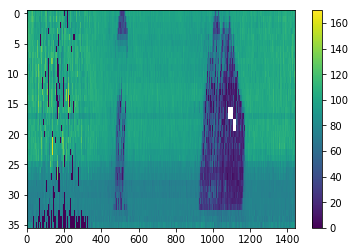

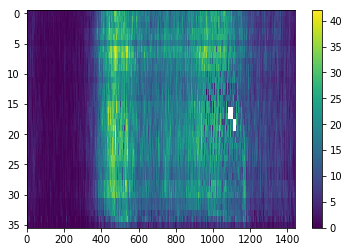

In [188]:
print(speeds.shape)
print(flows.shape)
plt.imshow(speeds, aspect = "auto")
plt.colorbar()
plt.show()
plt.imshow(flows, aspect = "auto")
plt.colorbar()
plt.show()

## Congestion

In [195]:
def parseSpeedFlowsToCongestions(speeds, flows):
    congestions = scipy.ndimage.filters.gaussian_filter(speeds, 3)
    return congestions

In [196]:
congestions = parseSpeedFlowsToCongestions(speeds, flows)

(36, 1440)


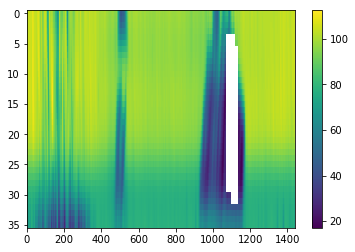

In [197]:
print(congestions.shape)
plt.imshow(congestions, aspect = "auto")
plt.colorbar()
plt.show()

## Congestion Filter

In [198]:
testDataArray = numpy.random.rand(16,9)
print(testDataArray >= 0.9)

[[False False False False False False False False False]
 [False  True False False False False False False False]
 [ True False False False False False False  True False]
 [False False False False False False False False False]
 [ True False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False  True  True  True False]
 [False  True False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False  True False  True False False False False False]
 [False False False False  True False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False  True False False False False False]]


In [199]:
def addBoundaries(ax, boundaries):
    rect = patches.Rectangle((
        boundaries[2] - 0.5,
        boundaries[0] - 0.5),
        boundaries[3] - boundaries[2] + 1,
        boundaries[1] - boundaries[0] + 1,
        linewidth = 1,
        edgecolor = "r",
        hatch = "//",
        facecolor = "none")
    ax.add_patch(rect)

In [200]:
def showDataWithBoundaries(dataArray, boundariesList):
    fig, ax = plt.subplots(1)
    ax.imshow(dataArray, aspect = "auto")
    for i in range(len(boundariesList)):
        addBoundaries(ax, boundariesList[i])
    plt.show()

In [201]:
def scan(dataArray, boundaries = None, threshold = 1, depth = 0):
    dprint("Starting scan...", depth)
    if boundaries is None:
        boundaries = [0, dataArray.shape[0] - 1, 0, dataArray.shape[1] - 1]
    boundariesList = []
    subArray = dataArray[boundaries[0]:boundaries[1] + 1, boundaries[2]:boundaries[3] + 1]
    arrayBoolean = numpy.any(subArray < threshold, depth % 2)
    if depth % 2:
        length = boundaries[1] + 1 - boundaries[0]
    else:
        length = boundaries[3] + 1 - boundaries[2]
    started = False
    if length > 1:
        childBoundaries = boundaries[:]
        for i in range(length):
            if arrayBoolean[i] and not started:
                dprint("Found start: " + str(i), depth)
                if depth % 2:
                    childBoundaries[0] = boundaries[0] + i
                else:
                    childBoundaries[2] = boundaries[2] + i
                started = True
            elif not arrayBoolean[i] and started:
                dprint("Found stop: " + str(i - 1), depth)
                if depth % 2:
                    childBoundaries[1] = boundaries[0] + i - 1
                else:
                    childBoundaries[3] = boundaries[2] + i - 1
                started = False
                boundariesList.append(childBoundaries[:])
        if started:
            dprint("Found stop at end.", depth)
            if depth % 2:
                childBoundaries[1] = boundaries[1]
            else:
                childBoundaries[3] = boundaries[3]
            boundariesList.append(childBoundaries)
    else:
        dprint("Length is one", depth)
        boundariesList.append(boundaries)
    dprint("Ending scan...", depth)
    return boundariesList

In [202]:
scan(testDataArray, threshold = 0.1, depth = 0)

2017-11-28 15:41:25 | Starting scan...
2017-11-28 15:41:25 | Found start: 0
2017-11-28 15:41:25 | Found stop: 3
2017-11-28 15:41:25 | Found start: 5
2017-11-28 15:41:25 | Found stop: 5
2017-11-28 15:41:25 | Found start: 7
2017-11-28 15:41:25 | Found stop at end.
2017-11-28 15:41:25 | Ending scan...


[[0, 15, 0, 3], [0, 15, 5, 5], [0, 15, 7, 8]]

In [203]:
def recursiveScan(dataArray, boundaries = None, depth = 0, parentLength = 0, threshold = 1): # Remove copies?
    dprint("Starting recursiveScan...", depth)
    dprint("Direction: " + str(depth % 2), depth)
    result = []
    boundariesList = scan(dataArray, boundaries, threshold, depth)
    showDataWithBoundaries(dataArray, boundariesList)
    length = len(boundariesList)
    dprint("length: " + str(length), depth)
    dprint("parentLength: " + str(parentLength), depth)
    if length == 0:
        dprint("Error: nothing found...", depth) # Throw Exception?
    elif length == 1 and parentLength == 1:
        dprint("Done: " + str(boundariesList[0]))
        return boundariesList
    else:
        dprint("Scanning children...", depth)
        parentLength = length;
        childDepth = depth + 1;
        for i in range(length):
            dprint("Child: " + str(i), depth)
            childBoundaries = boundariesList[i][:]
            result += recursiveScan(dataArray, childBoundaries, childDepth, parentLength, threshold)
    return result
    dprint("Ending recursiveScan...", depth)

2017-11-28 15:41:27 | Starting recursiveScan...
2017-11-28 15:41:27 | Direction: 0
2017-11-28 15:41:27 | Starting scan...
2017-11-28 15:41:27 | Found start: 0
2017-11-28 15:41:27 | Found stop: 3
2017-11-28 15:41:27 | Found start: 5
2017-11-28 15:41:27 | Found stop: 5
2017-11-28 15:41:27 | Found start: 7
2017-11-28 15:41:27 | Found stop at end.
2017-11-28 15:41:27 | Ending scan...


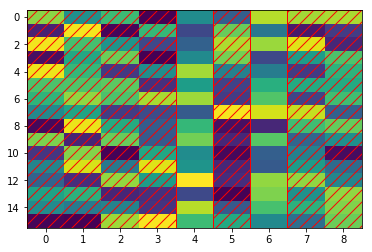

2017-11-28 15:41:27 | length: 3
2017-11-28 15:41:27 | parentLength: 0
2017-11-28 15:41:27 | Scanning children...
2017-11-28 15:41:27 | Child: 0
  2017-11-28 15:41:27 | Starting recursiveScan...
  2017-11-28 15:41:27 | Direction: 1
  2017-11-28 15:41:27 | Starting scan...
  2017-11-28 15:41:27 | Found start: 0
  2017-11-28 15:41:27 | Found stop: 1
  2017-11-28 15:41:27 | Found start: 3
  2017-11-28 15:41:27 | Found stop: 3
  2017-11-28 15:41:27 | Found start: 8
  2017-11-28 15:41:27 | Found stop: 8
  2017-11-28 15:41:27 | Found start: 10
  2017-11-28 15:41:27 | Found stop: 10
  2017-11-28 15:41:27 | Found start: 15
  2017-11-28 15:41:27 | Found stop at end.
  2017-11-28 15:41:27 | Ending scan...


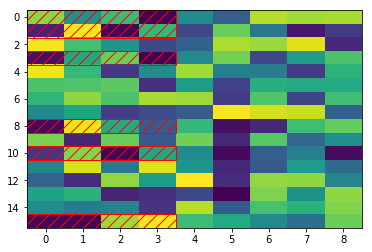

  2017-11-28 15:41:27 | length: 5
  2017-11-28 15:41:27 | parentLength: 3
  2017-11-28 15:41:27 | Scanning children...
  2017-11-28 15:41:27 | Child: 0
    2017-11-28 15:41:27 | Starting recursiveScan...
    2017-11-28 15:41:27 | Direction: 0
    2017-11-28 15:41:27 | Starting scan...
    2017-11-28 15:41:27 | Found start: 2
    2017-11-28 15:41:27 | Found stop at end.
    2017-11-28 15:41:27 | Ending scan...


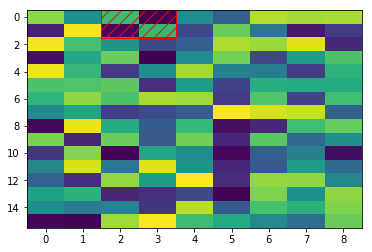

    2017-11-28 15:41:27 | length: 1
    2017-11-28 15:41:27 | parentLength: 5
    2017-11-28 15:41:27 | Scanning children...
    2017-11-28 15:41:27 | Child: 0
      2017-11-28 15:41:27 | Starting recursiveScan...
      2017-11-28 15:41:27 | Direction: 1
      2017-11-28 15:41:27 | Starting scan...
      2017-11-28 15:41:27 | Found start: 0
      2017-11-28 15:41:27 | Found stop at end.
      2017-11-28 15:41:27 | Ending scan...


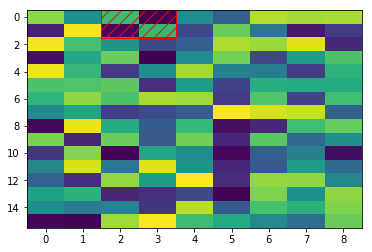

      2017-11-28 15:41:27 | length: 1
      2017-11-28 15:41:27 | parentLength: 1
2017-11-28 15:41:27 | Done: [0, 1, 2, 3]
  2017-11-28 15:41:27 | Child: 1
    2017-11-28 15:41:27 | Starting recursiveScan...
    2017-11-28 15:41:27 | Direction: 0
    2017-11-28 15:41:27 | Starting scan...
    2017-11-28 15:41:27 | Found start: 0
    2017-11-28 15:41:27 | Found stop: 0
    2017-11-28 15:41:27 | Found start: 3
    2017-11-28 15:41:27 | Found stop at end.
    2017-11-28 15:41:27 | Ending scan...


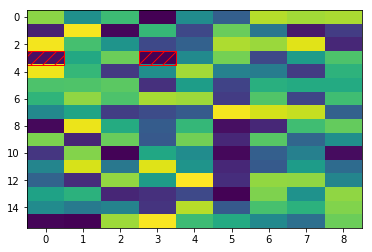

    2017-11-28 15:41:28 | length: 2
    2017-11-28 15:41:28 | parentLength: 5
    2017-11-28 15:41:28 | Scanning children...
    2017-11-28 15:41:28 | Child: 0
      2017-11-28 15:41:28 | Starting recursiveScan...
      2017-11-28 15:41:28 | Direction: 1
      2017-11-28 15:41:28 | Starting scan...
      2017-11-28 15:41:28 | Length is one
      2017-11-28 15:41:28 | Ending scan...


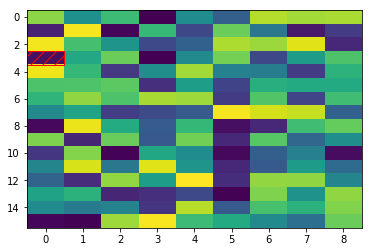

      2017-11-28 15:41:28 | length: 1
      2017-11-28 15:41:28 | parentLength: 2
      2017-11-28 15:41:28 | Scanning children...
      2017-11-28 15:41:28 | Child: 0
        2017-11-28 15:41:28 | Starting recursiveScan...
        2017-11-28 15:41:28 | Direction: 0
        2017-11-28 15:41:28 | Starting scan...
        2017-11-28 15:41:28 | Length is one
        2017-11-28 15:41:28 | Ending scan...


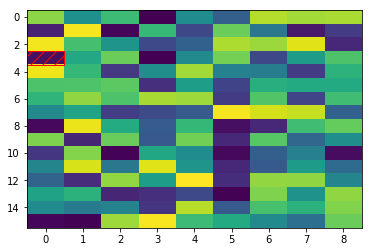

        2017-11-28 15:41:28 | length: 1
        2017-11-28 15:41:28 | parentLength: 1
2017-11-28 15:41:28 | Done: [3, 3, 0, 0]
    2017-11-28 15:41:28 | Child: 1
      2017-11-28 15:41:28 | Starting recursiveScan...
      2017-11-28 15:41:28 | Direction: 1
      2017-11-28 15:41:28 | Starting scan...
      2017-11-28 15:41:28 | Length is one
      2017-11-28 15:41:28 | Ending scan...


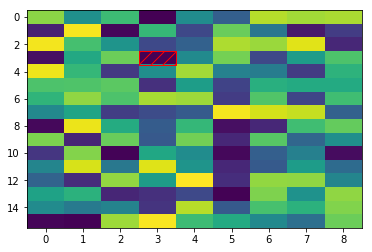

      2017-11-28 15:41:28 | length: 1
      2017-11-28 15:41:28 | parentLength: 2
      2017-11-28 15:41:28 | Scanning children...
      2017-11-28 15:41:28 | Child: 0
        2017-11-28 15:41:28 | Starting recursiveScan...
        2017-11-28 15:41:28 | Direction: 0
        2017-11-28 15:41:28 | Starting scan...
        2017-11-28 15:41:28 | Length is one
        2017-11-28 15:41:28 | Ending scan...


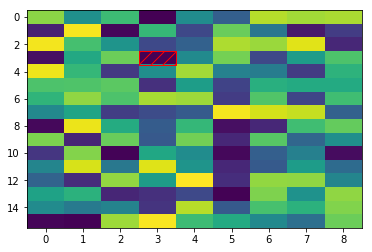

        2017-11-28 15:41:28 | length: 1
        2017-11-28 15:41:28 | parentLength: 1
2017-11-28 15:41:28 | Done: [3, 3, 3, 3]
  2017-11-28 15:41:28 | Child: 2
    2017-11-28 15:41:28 | Starting recursiveScan...
    2017-11-28 15:41:28 | Direction: 0
    2017-11-28 15:41:28 | Starting scan...
    2017-11-28 15:41:28 | Found start: 0
    2017-11-28 15:41:28 | Found stop: 0
    2017-11-28 15:41:28 | Ending scan...


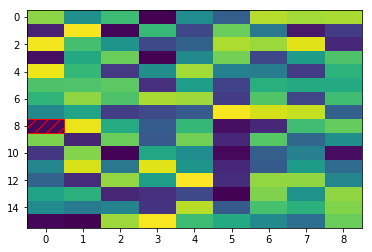

    2017-11-28 15:41:28 | length: 1
    2017-11-28 15:41:28 | parentLength: 5
    2017-11-28 15:41:28 | Scanning children...
    2017-11-28 15:41:28 | Child: 0
      2017-11-28 15:41:28 | Starting recursiveScan...
      2017-11-28 15:41:28 | Direction: 1
      2017-11-28 15:41:28 | Starting scan...
      2017-11-28 15:41:28 | Length is one
      2017-11-28 15:41:28 | Ending scan...


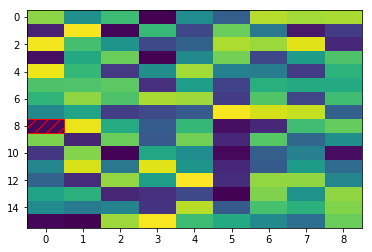

      2017-11-28 15:41:28 | length: 1
      2017-11-28 15:41:28 | parentLength: 1
2017-11-28 15:41:28 | Done: [8, 8, 0, 0]
  2017-11-28 15:41:28 | Child: 3
    2017-11-28 15:41:28 | Starting recursiveScan...
    2017-11-28 15:41:28 | Direction: 0
    2017-11-28 15:41:28 | Starting scan...
    2017-11-28 15:41:28 | Found start: 2
    2017-11-28 15:41:28 | Found stop: 2
    2017-11-28 15:41:28 | Ending scan...


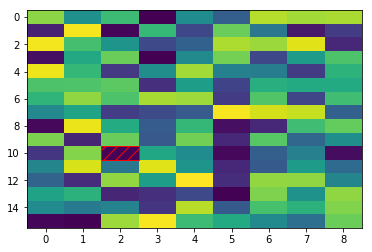

    2017-11-28 15:41:29 | length: 1
    2017-11-28 15:41:29 | parentLength: 5
    2017-11-28 15:41:29 | Scanning children...
    2017-11-28 15:41:29 | Child: 0
      2017-11-28 15:41:29 | Starting recursiveScan...
      2017-11-28 15:41:29 | Direction: 1
      2017-11-28 15:41:29 | Starting scan...
      2017-11-28 15:41:29 | Length is one
      2017-11-28 15:41:29 | Ending scan...


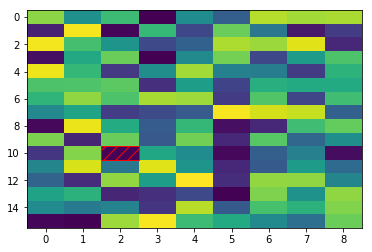

      2017-11-28 15:41:29 | length: 1
      2017-11-28 15:41:29 | parentLength: 1
2017-11-28 15:41:29 | Done: [10, 10, 2, 2]
  2017-11-28 15:41:29 | Child: 4
    2017-11-28 15:41:29 | Starting recursiveScan...
    2017-11-28 15:41:29 | Direction: 0
    2017-11-28 15:41:29 | Starting scan...
    2017-11-28 15:41:29 | Found start: 0
    2017-11-28 15:41:29 | Found stop: 1
    2017-11-28 15:41:29 | Ending scan...


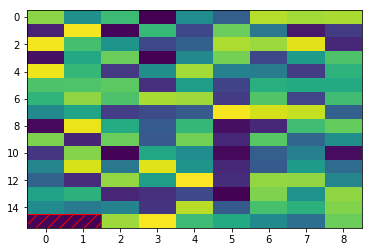

    2017-11-28 15:41:29 | length: 1
    2017-11-28 15:41:29 | parentLength: 5
    2017-11-28 15:41:29 | Scanning children...
    2017-11-28 15:41:29 | Child: 0
      2017-11-28 15:41:29 | Starting recursiveScan...
      2017-11-28 15:41:29 | Direction: 1
      2017-11-28 15:41:29 | Starting scan...
      2017-11-28 15:41:29 | Length is one
      2017-11-28 15:41:29 | Ending scan...


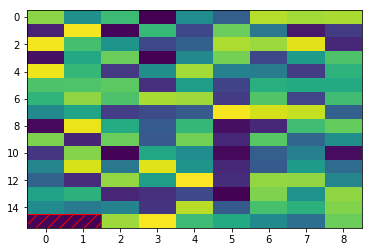

      2017-11-28 15:41:29 | length: 1
      2017-11-28 15:41:29 | parentLength: 1
2017-11-28 15:41:29 | Done: [15, 15, 0, 1]
2017-11-28 15:41:29 | Child: 1
  2017-11-28 15:41:29 | Starting recursiveScan...
  2017-11-28 15:41:29 | Direction: 1
  2017-11-28 15:41:29 | Starting scan...
  2017-11-28 15:41:29 | Found start: 8
  2017-11-28 15:41:29 | Found stop: 8
  2017-11-28 15:41:29 | Found start: 10
  2017-11-28 15:41:29 | Found stop: 10
  2017-11-28 15:41:29 | Found start: 13
  2017-11-28 15:41:29 | Found stop: 13
  2017-11-28 15:41:29 | Ending scan...


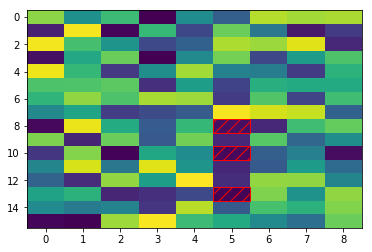

  2017-11-28 15:41:29 | length: 3
  2017-11-28 15:41:29 | parentLength: 3
  2017-11-28 15:41:29 | Scanning children...
  2017-11-28 15:41:29 | Child: 0
    2017-11-28 15:41:29 | Starting recursiveScan...
    2017-11-28 15:41:29 | Direction: 0
    2017-11-28 15:41:29 | Starting scan...
    2017-11-28 15:41:29 | Length is one
    2017-11-28 15:41:29 | Ending scan...


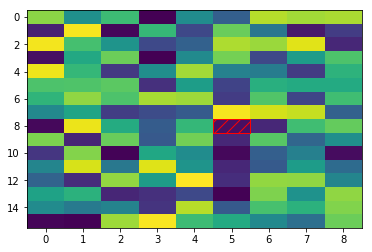

    2017-11-28 15:41:29 | length: 1
    2017-11-28 15:41:29 | parentLength: 3
    2017-11-28 15:41:29 | Scanning children...
    2017-11-28 15:41:29 | Child: 0
      2017-11-28 15:41:29 | Starting recursiveScan...
      2017-11-28 15:41:29 | Direction: 1
      2017-11-28 15:41:29 | Starting scan...
      2017-11-28 15:41:29 | Length is one
      2017-11-28 15:41:29 | Ending scan...


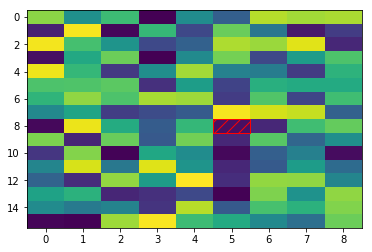

      2017-11-28 15:41:29 | length: 1
      2017-11-28 15:41:29 | parentLength: 1
2017-11-28 15:41:29 | Done: [8, 8, 5, 5]
  2017-11-28 15:41:29 | Child: 1
    2017-11-28 15:41:29 | Starting recursiveScan...
    2017-11-28 15:41:29 | Direction: 0
    2017-11-28 15:41:29 | Starting scan...
    2017-11-28 15:41:29 | Length is one
    2017-11-28 15:41:29 | Ending scan...


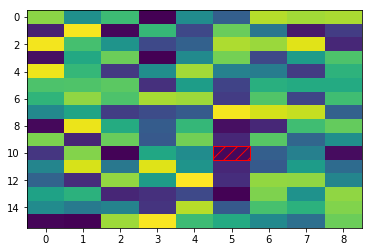

    2017-11-28 15:41:29 | length: 1
    2017-11-28 15:41:29 | parentLength: 3
    2017-11-28 15:41:29 | Scanning children...
    2017-11-28 15:41:29 | Child: 0
      2017-11-28 15:41:29 | Starting recursiveScan...
      2017-11-28 15:41:29 | Direction: 1
      2017-11-28 15:41:29 | Starting scan...
      2017-11-28 15:41:29 | Length is one
      2017-11-28 15:41:29 | Ending scan...


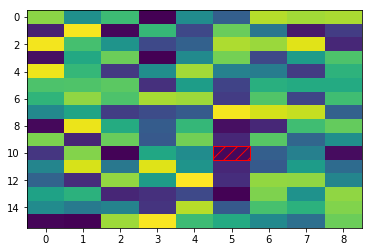

      2017-11-28 15:41:30 | length: 1
      2017-11-28 15:41:30 | parentLength: 1
2017-11-28 15:41:30 | Done: [10, 10, 5, 5]
  2017-11-28 15:41:30 | Child: 2
    2017-11-28 15:41:30 | Starting recursiveScan...
    2017-11-28 15:41:30 | Direction: 0
    2017-11-28 15:41:30 | Starting scan...
    2017-11-28 15:41:30 | Length is one
    2017-11-28 15:41:30 | Ending scan...


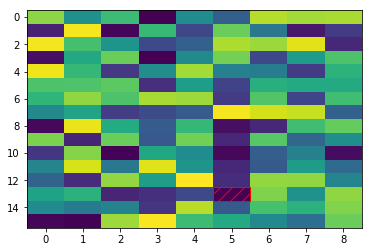

    2017-11-28 15:41:30 | length: 1
    2017-11-28 15:41:30 | parentLength: 3
    2017-11-28 15:41:30 | Scanning children...
    2017-11-28 15:41:30 | Child: 0
      2017-11-28 15:41:30 | Starting recursiveScan...
      2017-11-28 15:41:30 | Direction: 1
      2017-11-28 15:41:30 | Starting scan...
      2017-11-28 15:41:30 | Length is one
      2017-11-28 15:41:30 | Ending scan...


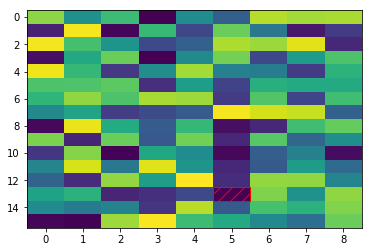

      2017-11-28 15:41:30 | length: 1
      2017-11-28 15:41:30 | parentLength: 1
2017-11-28 15:41:30 | Done: [13, 13, 5, 5]
2017-11-28 15:41:30 | Child: 2
  2017-11-28 15:41:30 | Starting recursiveScan...
  2017-11-28 15:41:30 | Direction: 1
  2017-11-28 15:41:30 | Starting scan...
  2017-11-28 15:41:30 | Found start: 1
  2017-11-28 15:41:30 | Found stop: 1
  2017-11-28 15:41:30 | Found start: 10
  2017-11-28 15:41:30 | Found stop: 10
  2017-11-28 15:41:30 | Ending scan...


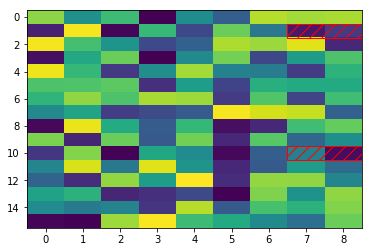

  2017-11-28 15:41:30 | length: 2
  2017-11-28 15:41:30 | parentLength: 3
  2017-11-28 15:41:30 | Scanning children...
  2017-11-28 15:41:30 | Child: 0
    2017-11-28 15:41:30 | Starting recursiveScan...
    2017-11-28 15:41:30 | Direction: 0
    2017-11-28 15:41:30 | Starting scan...
    2017-11-28 15:41:30 | Found start: 0
    2017-11-28 15:41:30 | Found stop: 0
    2017-11-28 15:41:30 | Ending scan...


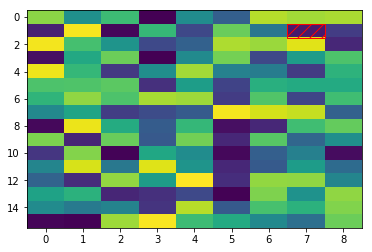

    2017-11-28 15:41:30 | length: 1
    2017-11-28 15:41:30 | parentLength: 2
    2017-11-28 15:41:30 | Scanning children...
    2017-11-28 15:41:30 | Child: 0
      2017-11-28 15:41:30 | Starting recursiveScan...
      2017-11-28 15:41:30 | Direction: 1
      2017-11-28 15:41:30 | Starting scan...
      2017-11-28 15:41:30 | Length is one
      2017-11-28 15:41:30 | Ending scan...


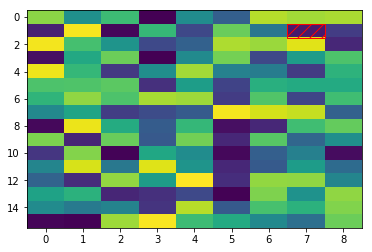

      2017-11-28 15:41:30 | length: 1
      2017-11-28 15:41:30 | parentLength: 1
2017-11-28 15:41:30 | Done: [1, 1, 7, 7]
  2017-11-28 15:41:30 | Child: 1
    2017-11-28 15:41:30 | Starting recursiveScan...
    2017-11-28 15:41:30 | Direction: 0
    2017-11-28 15:41:30 | Starting scan...
    2017-11-28 15:41:30 | Found start: 1
    2017-11-28 15:41:30 | Found stop at end.
    2017-11-28 15:41:30 | Ending scan...


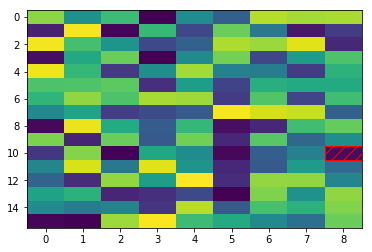

    2017-11-28 15:41:30 | length: 1
    2017-11-28 15:41:30 | parentLength: 2
    2017-11-28 15:41:30 | Scanning children...
    2017-11-28 15:41:30 | Child: 0
      2017-11-28 15:41:30 | Starting recursiveScan...
      2017-11-28 15:41:30 | Direction: 1
      2017-11-28 15:41:30 | Starting scan...
      2017-11-28 15:41:30 | Length is one
      2017-11-28 15:41:30 | Ending scan...


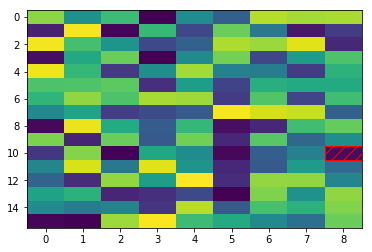

      2017-11-28 15:41:31 | length: 1
      2017-11-28 15:41:31 | parentLength: 1
2017-11-28 15:41:31 | Done: [10, 10, 8, 8]


In [204]:
testBoundariesList = recursiveScan(testDataArray, threshold = 0.1)

In [181]:
testBoundariesList

[[2, 2, 0, 0],
 [5, 5, 0, 0],
 [5, 5, 2, 2],
 [7, 7, 1, 1],
 [11, 12, 0, 0],
 [11, 12, 2, 3],
 [0, 0, 5, 5],
 [3, 3, 6, 6],
 [6, 6, 5, 5],
 [13, 13, 8, 8],
 [15, 15, 8, 8]]

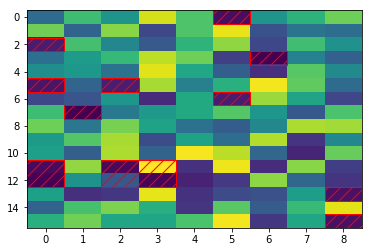

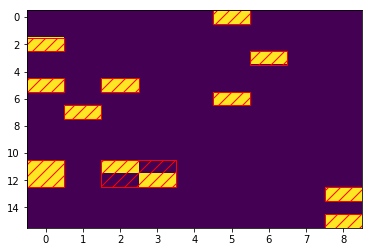

In [182]:
showDataWithBoundaries(testDataArray, testBoundariesList)
showDataWithBoundaries(testDataArray < 0.1, testBoundariesList)

2017-11-28 15:42:56 | Starting recursiveScan...
2017-11-28 15:42:56 | Direction: 0
2017-11-28 15:42:56 | Starting scan...
2017-11-28 15:42:56 | Found start: 130
2017-11-28 15:42:56 | Found stop: 134
2017-11-28 15:42:56 | Found start: 142
2017-11-28 15:42:56 | Found stop: 143
2017-11-28 15:42:56 | Found start: 151
2017-11-28 15:42:56 | Found stop: 156
2017-11-28 15:42:56 | Found start: 168
2017-11-28 15:42:56 | Found stop: 178
2017-11-28 15:42:56 | Found start: 197
2017-11-28 15:42:56 | Found stop: 205
2017-11-28 15:42:56 | Found start: 225
2017-11-28 15:42:56 | Found stop: 238
2017-11-28 15:42:56 | Found start: 242
2017-11-28 15:42:56 | Found stop: 249
2017-11-28 15:42:56 | Found start: 275
2017-11-28 15:42:56 | Found stop: 283
2017-11-28 15:42:56 | Found start: 939
2017-11-28 15:42:56 | Found stop: 1096
2017-11-28 15:42:56 | Found start: 1133
2017-11-28 15:42:56 | Found stop: 1164
2017-11-28 15:42:56 | Ending scan...


C:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


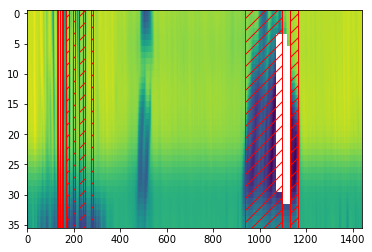

2017-11-28 15:42:56 | length: 10
2017-11-28 15:42:56 | parentLength: 0
2017-11-28 15:42:56 | Scanning children...
2017-11-28 15:42:56 | Child: 0
  2017-11-28 15:42:56 | Starting recursiveScan...
  2017-11-28 15:42:56 | Direction: 1
  2017-11-28 15:42:56 | Starting scan...
  2017-11-28 15:42:56 | Found start: 34
  2017-11-28 15:42:56 | Found stop at end.
  2017-11-28 15:42:56 | Ending scan...


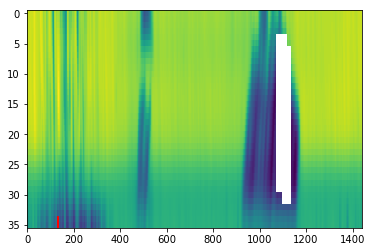

  2017-11-28 15:42:56 | length: 1
  2017-11-28 15:42:56 | parentLength: 10
  2017-11-28 15:42:56 | Scanning children...
  2017-11-28 15:42:56 | Child: 0
    2017-11-28 15:42:56 | Starting recursiveScan...
    2017-11-28 15:42:56 | Direction: 0
    2017-11-28 15:42:56 | Starting scan...
    2017-11-28 15:42:56 | Found start: 0
    2017-11-28 15:42:56 | Found stop at end.
    2017-11-28 15:42:56 | Ending scan...


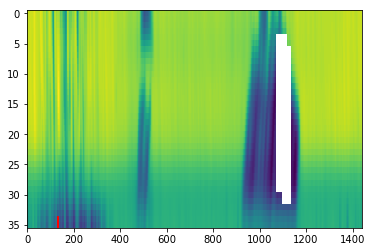

    2017-11-28 15:42:56 | length: 1
    2017-11-28 15:42:56 | parentLength: 1
2017-11-28 15:42:56 | Done: [34, 35, 130, 134]
2017-11-28 15:42:56 | Child: 1
  2017-11-28 15:42:56 | Starting recursiveScan...
  2017-11-28 15:42:56 | Direction: 1
  2017-11-28 15:42:56 | Starting scan...
  2017-11-28 15:42:56 | Found start: 35
  2017-11-28 15:42:56 | Found stop at end.
  2017-11-28 15:42:56 | Ending scan...


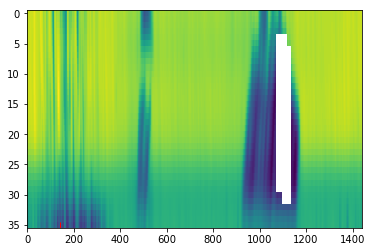

  2017-11-28 15:42:56 | length: 1
  2017-11-28 15:42:56 | parentLength: 10
  2017-11-28 15:42:56 | Scanning children...
  2017-11-28 15:42:56 | Child: 0
    2017-11-28 15:42:56 | Starting recursiveScan...
    2017-11-28 15:42:56 | Direction: 0
    2017-11-28 15:42:56 | Starting scan...
    2017-11-28 15:42:56 | Found start: 0
    2017-11-28 15:42:56 | Found stop at end.
    2017-11-28 15:42:56 | Ending scan...


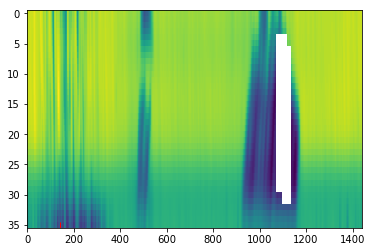

    2017-11-28 15:42:56 | length: 1
    2017-11-28 15:42:56 | parentLength: 1
2017-11-28 15:42:56 | Done: [35, 35, 142, 143]
2017-11-28 15:42:56 | Child: 2
  2017-11-28 15:42:56 | Starting recursiveScan...
  2017-11-28 15:42:56 | Direction: 1
  2017-11-28 15:42:56 | Starting scan...
  2017-11-28 15:42:56 | Found start: 34
  2017-11-28 15:42:56 | Found stop at end.
  2017-11-28 15:42:56 | Ending scan...


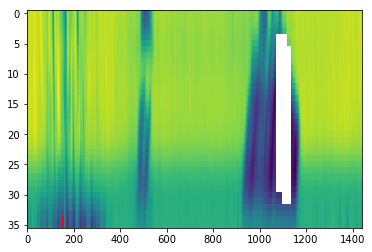

  2017-11-28 15:42:57 | length: 1
  2017-11-28 15:42:57 | parentLength: 10
  2017-11-28 15:42:57 | Scanning children...
  2017-11-28 15:42:57 | Child: 0
    2017-11-28 15:42:57 | Starting recursiveScan...
    2017-11-28 15:42:57 | Direction: 0
    2017-11-28 15:42:57 | Starting scan...
    2017-11-28 15:42:57 | Found start: 0
    2017-11-28 15:42:57 | Found stop at end.
    2017-11-28 15:42:57 | Ending scan...


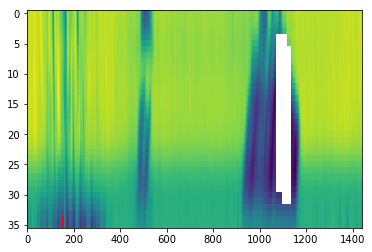

    2017-11-28 15:42:57 | length: 1
    2017-11-28 15:42:57 | parentLength: 1
2017-11-28 15:42:57 | Done: [34, 35, 151, 156]
2017-11-28 15:42:57 | Child: 3
  2017-11-28 15:42:57 | Starting recursiveScan...
  2017-11-28 15:42:57 | Direction: 1
  2017-11-28 15:42:57 | Starting scan...
  2017-11-28 15:42:57 | Found start: 33
  2017-11-28 15:42:57 | Found stop at end.
  2017-11-28 15:42:57 | Ending scan...


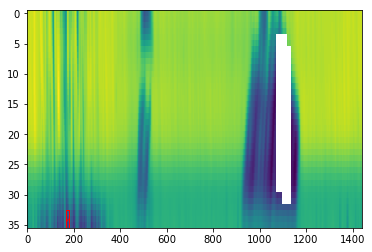

  2017-11-28 15:42:57 | length: 1
  2017-11-28 15:42:57 | parentLength: 10
  2017-11-28 15:42:57 | Scanning children...
  2017-11-28 15:42:57 | Child: 0
    2017-11-28 15:42:57 | Starting recursiveScan...
    2017-11-28 15:42:57 | Direction: 0
    2017-11-28 15:42:57 | Starting scan...
    2017-11-28 15:42:57 | Found start: 0
    2017-11-28 15:42:57 | Found stop at end.
    2017-11-28 15:42:57 | Ending scan...


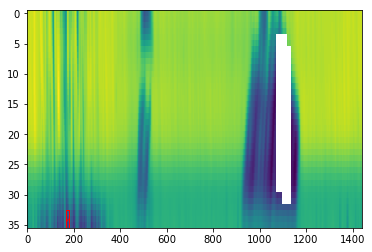

    2017-11-28 15:42:57 | length: 1
    2017-11-28 15:42:57 | parentLength: 1
2017-11-28 15:42:57 | Done: [33, 35, 168, 178]
2017-11-28 15:42:57 | Child: 4
  2017-11-28 15:42:57 | Starting recursiveScan...
  2017-11-28 15:42:57 | Direction: 1
  2017-11-28 15:42:57 | Starting scan...
  2017-11-28 15:42:57 | Found start: 32
  2017-11-28 15:42:57 | Found stop at end.
  2017-11-28 15:42:57 | Ending scan...


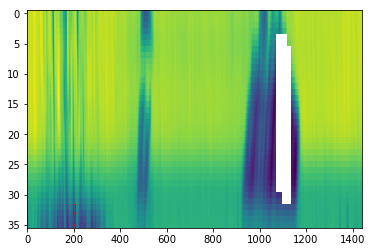

  2017-11-28 15:42:57 | length: 1
  2017-11-28 15:42:57 | parentLength: 10
  2017-11-28 15:42:57 | Scanning children...
  2017-11-28 15:42:57 | Child: 0
    2017-11-28 15:42:57 | Starting recursiveScan...
    2017-11-28 15:42:57 | Direction: 0
    2017-11-28 15:42:57 | Starting scan...
    2017-11-28 15:42:57 | Found start: 0
    2017-11-28 15:42:57 | Found stop at end.
    2017-11-28 15:42:57 | Ending scan...


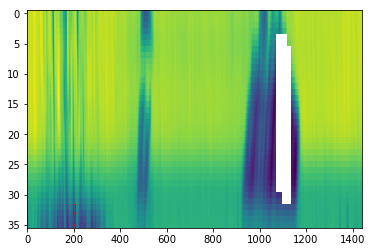

    2017-11-28 15:42:57 | length: 1
    2017-11-28 15:42:57 | parentLength: 1
2017-11-28 15:42:57 | Done: [32, 35, 197, 205]
2017-11-28 15:42:57 | Child: 5
  2017-11-28 15:42:57 | Starting recursiveScan...
  2017-11-28 15:42:57 | Direction: 1
  2017-11-28 15:42:57 | Starting scan...
  2017-11-28 15:42:57 | Found start: 34
  2017-11-28 15:42:57 | Found stop at end.
  2017-11-28 15:42:57 | Ending scan...


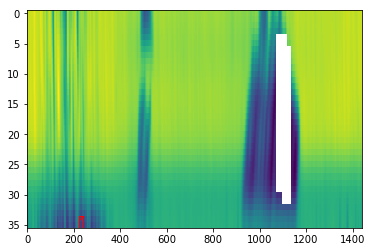

  2017-11-28 15:42:57 | length: 1
  2017-11-28 15:42:57 | parentLength: 10
  2017-11-28 15:42:57 | Scanning children...
  2017-11-28 15:42:57 | Child: 0
    2017-11-28 15:42:57 | Starting recursiveScan...
    2017-11-28 15:42:57 | Direction: 0
    2017-11-28 15:42:57 | Starting scan...
    2017-11-28 15:42:57 | Found start: 0
    2017-11-28 15:42:57 | Found stop at end.
    2017-11-28 15:42:57 | Ending scan...


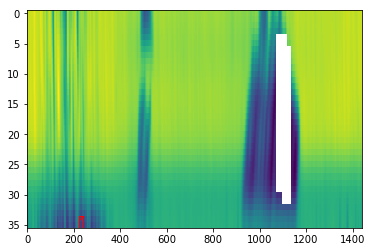

    2017-11-28 15:42:58 | length: 1
    2017-11-28 15:42:58 | parentLength: 1
2017-11-28 15:42:58 | Done: [34, 35, 225, 238]
2017-11-28 15:42:58 | Child: 6
  2017-11-28 15:42:58 | Starting recursiveScan...
  2017-11-28 15:42:58 | Direction: 1
  2017-11-28 15:42:58 | Starting scan...
  2017-11-28 15:42:58 | Found start: 34
  2017-11-28 15:42:58 | Found stop at end.
  2017-11-28 15:42:58 | Ending scan...


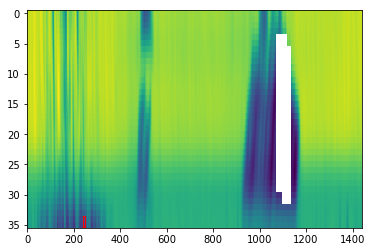

  2017-11-28 15:42:58 | length: 1
  2017-11-28 15:42:58 | parentLength: 10
  2017-11-28 15:42:58 | Scanning children...
  2017-11-28 15:42:58 | Child: 0
    2017-11-28 15:42:58 | Starting recursiveScan...
    2017-11-28 15:42:58 | Direction: 0
    2017-11-28 15:42:58 | Starting scan...
    2017-11-28 15:42:58 | Found start: 0
    2017-11-28 15:42:58 | Found stop at end.
    2017-11-28 15:42:58 | Ending scan...


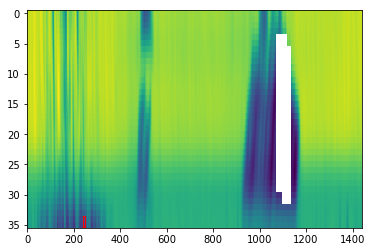

    2017-11-28 15:42:58 | length: 1
    2017-11-28 15:42:58 | parentLength: 1
2017-11-28 15:42:58 | Done: [34, 35, 242, 249]
2017-11-28 15:42:58 | Child: 7
  2017-11-28 15:42:58 | Starting recursiveScan...
  2017-11-28 15:42:58 | Direction: 1
  2017-11-28 15:42:58 | Starting scan...
  2017-11-28 15:42:58 | Found start: 34
  2017-11-28 15:42:58 | Found stop at end.
  2017-11-28 15:42:58 | Ending scan...


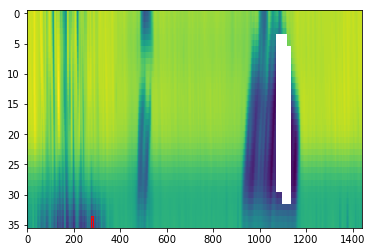

  2017-11-28 15:42:58 | length: 1
  2017-11-28 15:42:58 | parentLength: 10
  2017-11-28 15:42:58 | Scanning children...
  2017-11-28 15:42:58 | Child: 0
    2017-11-28 15:42:58 | Starting recursiveScan...
    2017-11-28 15:42:58 | Direction: 0
    2017-11-28 15:42:58 | Starting scan...
    2017-11-28 15:42:58 | Found start: 0
    2017-11-28 15:42:58 | Found stop at end.
    2017-11-28 15:42:58 | Ending scan...


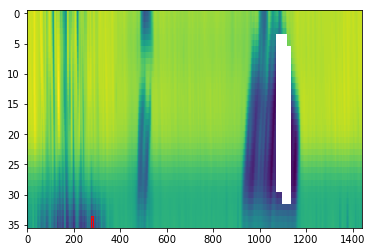

    2017-11-28 15:42:58 | length: 1
    2017-11-28 15:42:58 | parentLength: 1
2017-11-28 15:42:58 | Done: [34, 35, 275, 283]
2017-11-28 15:42:58 | Child: 8
  2017-11-28 15:42:58 | Starting recursiveScan...
  2017-11-28 15:42:58 | Direction: 1
  2017-11-28 15:42:58 | Starting scan...
  2017-11-28 15:42:58 | Found start: 8
  2017-11-28 15:42:58 | Found stop: 31
  2017-11-28 15:42:58 | Ending scan...


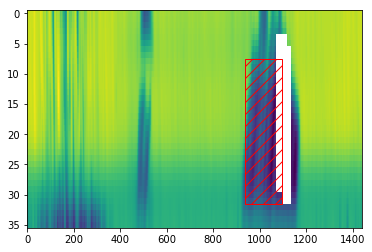

  2017-11-28 15:42:58 | length: 1
  2017-11-28 15:42:58 | parentLength: 10
  2017-11-28 15:42:58 | Scanning children...
  2017-11-28 15:42:58 | Child: 0
    2017-11-28 15:42:58 | Starting recursiveScan...
    2017-11-28 15:42:58 | Direction: 0
    2017-11-28 15:42:58 | Starting scan...
    2017-11-28 15:42:58 | Found start: 0
    2017-11-28 15:42:58 | Found stop at end.
    2017-11-28 15:42:58 | Ending scan...


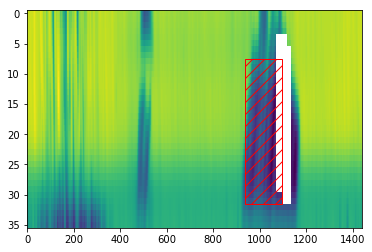

    2017-11-28 15:42:58 | length: 1
    2017-11-28 15:42:58 | parentLength: 1
2017-11-28 15:42:58 | Done: [8, 31, 939, 1096]
2017-11-28 15:42:58 | Child: 9
  2017-11-28 15:42:58 | Starting recursiveScan...
  2017-11-28 15:42:58 | Direction: 1
  2017-11-28 15:42:58 | Starting scan...
  2017-11-28 15:42:58 | Found start: 15
  2017-11-28 15:42:58 | Found stop: 31
  2017-11-28 15:42:58 | Ending scan...


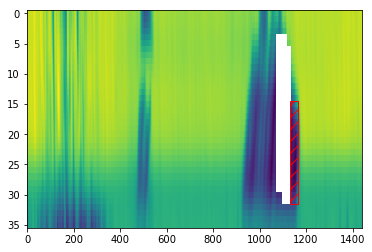

  2017-11-28 15:42:59 | length: 1
  2017-11-28 15:42:59 | parentLength: 10
  2017-11-28 15:42:59 | Scanning children...
  2017-11-28 15:42:59 | Child: 0
    2017-11-28 15:42:59 | Starting recursiveScan...
    2017-11-28 15:42:59 | Direction: 0
    2017-11-28 15:42:59 | Starting scan...
    2017-11-28 15:42:59 | Found start: 0
    2017-11-28 15:42:59 | Found stop at end.
    2017-11-28 15:42:59 | Ending scan...


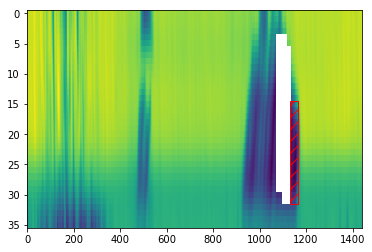

    2017-11-28 15:42:59 | length: 1
    2017-11-28 15:42:59 | parentLength: 1
2017-11-28 15:42:59 | Done: [15, 31, 1133, 1164]


In [209]:
congestionBoundariesList = recursiveScan(congestions, threshold = 40)

In [213]:
congestionBoundariesList

[[34, 35, 130, 134],
 [35, 35, 142, 143],
 [34, 35, 151, 156],
 [33, 35, 168, 178],
 [32, 35, 197, 205],
 [34, 35, 225, 238],
 [34, 35, 242, 249],
 [34, 35, 275, 283],
 [8, 31, 939, 1096],
 [15, 31, 1133, 1164]]

In [216]:
def addMargins(congestionBoundariesList):
    return congestionBoundariesList

In [217]:
congestionBoundariesList = addMargins(congestionBoundariesList)

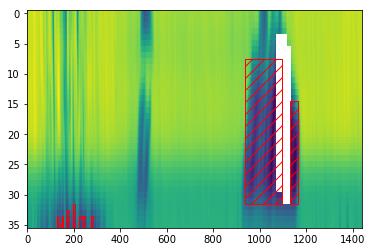

C:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


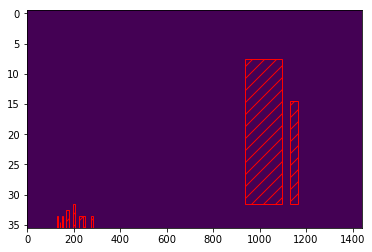

In [218]:
showDataWithBoundaries(congestions, congestionBoundariesList)
showDataWithBoundaries(congestions < 0.9, congestionBoundariesList)

End of Notebook